In [1]:
import numpy as np
import jax.random
import jax.numpy as jnp
import jax.scipy.optimize
import jaxopt
import optax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from shapely.geometry import Polygon, Point
from functools import partial

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.ioff()

import time
import pandas as pd
from datetime import datetime
import os
import pytz
import ast
from pypdf import PdfMerger

import contextlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Running parameters
num_iters = 600    # Number of training iterations
num_runs = 10
cl_types =  ["NCL", "RAND", "CL", "ACL"]  #["NCL", "CL", "ACL", "RAND", "SPCL", "SPACL", "PCL", "PACL", "FSPCL", "FSPACL"]    # "NCL" - No curriculum, "CL" - Curriculum, "ACL" - Anti-curriculum, "SPCL" - Self paced curriculum, "SPACL" - Self paced anti-curriculum
with_val = True

# Circuit and optimization parameters
nqubits = 8         # Num qubits, min 4, always 2**num_layers qubits
gate_id = "general"      # QCNN type, either "general", "a0"
with_bias = False    # Add a bias to the output of the quantum circuit
optimizer = "Adam"  # "Adam", "GradientDescent", "BFGS"
loss_type = "mean_squares" # "cross_entropy", "mean_squares"
initialization = "gaussian" # "gaussian", "uniform"

# Data hyper-parameters
ham = "ssh" # "gch" (Generalized Cluster Hamiltonian) or "ssh" (Su-Schrieffer-Heeger)
batch_size = 10     # batch training size
train_size = 50      # Total ground states that will be used for training
val_size = 1000      # Total gound states with training + validation

cl_iter_ratios = [1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20, 1/20]


# Logarithmic pace - 2024-05-30 18-33-00
# cl_pace_ratios = np.array([10,	9,	5,	4,	3,	2,	2,	2,	2,	1,	2,	1,	1,	1,	1,	1,	0,	1,	1,	1])/50

# Linear pace - 2024-05-30 14-09-59 
# cl_pace_ratios = np.array([10,	2,	2,	2,	2,	2,	2,	2,	2,	2,	3,	2,	2,	2,	2,	2,	2,	2,	2,	3])/50

# Exponential pace
cl_pace_ratios  = np.array([10,	0,	1,	1,	2,	1,	1,	2,	1,	2,	2,	2,	2,	3,	2,	3,	3,	4,	3,	5])/50  # exp = 1  - 2024-06-04 12-13-53
# cl_pace_ratios = np.array([10,	0,	0,	0,	1,	0,	1,	0,	1,	1,	2,	1,	2,	2,	3,	3,	4,	5,	6,	8])/50  # exp = 2  - 2024-05-30 17-37-52
# cl_pace_ratios = np.array([10,	0,	0,	0,	0,	0,	0,	0,	0,	1,	0,	1,	1,	1,	2,	3,	4,	5,	9,	13])/50  # exp = 4  - 2024-06-04 12-48-54


# Others
# cl_pace_ratios = [0.25, 0.25, 0.25, 0.25]
# cl_iter_ratios = [1/2, 1/4, 1/8, 1/8]
# cl_pace_ratios = [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]  #  [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],  [0.4, 0.3, 0.2, 0.1]    # [0.1, 0.2, 0.3, 0.4], [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [0.3, 0.2, 0.2, 0.2, 0.1]
# cl_iter_ratios  = [1/6, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/3] #  [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2]

gen_type = "a0"

# How the training data is generated
uniform_train = False    # True - Uniform, False - Balanced
uniform_val = False
epsilon_train = False   # True - epsilon, False - no epsilon
epsilon_val = False

# Tweak training hyper-parameters
max_weight_init = 2*np.pi  # weight_init goes from 0 to this number. Max = 2*np.pi. Other options = 0.01
stepsize = 0.01         # stepsize of the gradient descent.

# Constant definitions
layers = int(np.log2(nqubits))
gate_nweights = 15 if gate_id == "general" else 5
nweights = 2*gate_nweights*(layers-1) + gate_nweights

cl_pace = []
i_batch_size = 0
for i in range(len(cl_iter_ratios)):
    if i < len(cl_iter_ratios)-1:
        i_batch_size += int(cl_pace_ratios[i]*train_size)
        i_num_iters = int(cl_iter_ratios[i]*num_iters)
    else:
        i_batch_size = train_size
        i_num_iters = num_iters - len(cl_pace)
        
    cl_pace += [i_batch_size]*i_num_iters

if cl_pace[0] < batch_size:
    raise Exception(f"CL starts with {cl_pace[0]} samples but the batch is larger with {batch_size} samples")

# Ground states

In [3]:
def I(i):
    return qml.Identity(i)
def X(i):
    return qml.PauliX(i)
def Y(i):
    return qml.PauliY(i)
def Z(i):
    return qml.PauliZ(i)

In [4]:
# @jax.jit
def ground_state(j1, j2):
    
    hamiltonian = 0
    
    if ham == "gch":
        for i in range(nqubits):
            hamiltonian += Z(i)
            hamiltonian -= j1 * X(i) @ X((i+1)%nqubits)
            hamiltonian -= j2 * X((i-1)%nqubits) @ Z(i) @ X((i+1)%nqubits)
        
    elif ham == "ssh":
        for i in range(nqubits//2):
            hamiltonian += 1/2*(X(2*i)@X(2*i+1) + Y(2*i)@Y(2*i+1) + j2*Z(2*i)@Z(2*i+1))
        for i in range((nqubits-1)//2):
            hamiltonian += j1/2*(X(2*i+1)@X(2*i+2) + Y(2*i+1)@Y(2*i+2) + j2*Z(2*i+1)@Z(2*i+2))

        hamiltonian += j1/2*(X(nqubits-1)@X(0) + Y(nqubits-1)@Y(0) + j2*Z(nqubits-1)@Z(0))
    
    ham_matrix = qml.matrix(hamiltonian)
    _, eigvecs = jnp.linalg.eigh(ham_matrix)
    
    return eigvecs[:,0]

In [5]:
# def built_matrix_R(n):

#     def rev(a, num_bits):
#         bin_a = bin(a)[2:]
#         c = ("0"*(num_bits-len(bin_a)) + bin_a)[::-1]
#         return int(c,2)

#     matrix_R = np.zeros(shape=(2**n, 2**n))
#     for i in range(2**n):
#         matrix_R[rev(i, n), i] = 1
    
#     return matrix_R

# def calc_ZR(rho, nqubits, n):

#     matrix_R = built_matrix_R(n)
#     nI1 = list(range((nqubits-n)//2))
#     I1 = list(range((nqubits-n)//2, nqubits//2))
#     I2 = list(range(nqubits//2, (nqubits+n)//2))
#     nI2 = list(range((nqubits+n)//2, nqubits))

#     rho_I = qml.math.partial_trace(rho, nI1 + nI2)
#     rho_I1 = qml.math.partial_trace(rho, nI1 + I2 + nI2)
#     # rho_I1 = qml.math.partial_trace(rho_I, list(range(n//2, n)))
#     rho_I2 = qml.math.partial_trace(rho, nI1 + I1 + nI2)
#     # rho_I2 = qml.math.partial_trace(rho_I, list(range(n//2)))

#     ZR = np.trace(matrix_R @ rho_I)
#     denom = np.sqrt((np.trace(rho_I1 @ rho_I1)+np.trace(rho_I2 @ rho_I2))/2)
#     # print(ZR, denom, ZR/denom)
    
#     return np.real(ZR/denom)

In [6]:
# nqubits = 8
# n = 6

# xx, yy = np.meshgrid(np.linspace(0, 3, 10), np.linspace(0, 4, 10))
# X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# gs = [ground_state(j1, j2) for j1,j2 in X_grid]
# rhos = [np.tensordot(g, np.conjugate(g), axes=0) for g in gs]

# predictions_grid = [calc_ZR(r, nqubits, n) for r in rhos]
# pred_grid = np.reshape(predictions_grid, xx.shape)

In [7]:
# plt.figure()
# cm = plt.cm.RdBu

# mx = max(predictions_grid)
# mn = min(predictions_grid)

# cnt = plt.contourf(
#     xx, yy, pred_grid, levels=np.arange(mn, mx, (mx-mn)/20), cmap=cm, alpha=0.8, extend="both"
# )
# plt.colorbar(cnt, ticks=[mn, (mx+mn)/2, mx])
# # plt.axis('square')
# plt.show()

In [8]:
# Define coordinates of the points of each region# Definir las coordenadas de los puntos de cada región
region01_coords = np.array([(-2, 1), (2, 1), (4, 3), (4, 4), (-4, 4), (-4, 3)])    # Class 0
region02_coords = np.array([(-3, -4), (0, -1), (3, -4)])                           # Class 0
region1_coords = np.array([(0, -1), (3, -4), (4, -4), (4, 3)])                     # Class 1
region2_coords = np.array([(0, -1), (-3, -4), (-4, -4), (-4, 3)])                  # Class 2
region3_coords = np.array([(-2, 1), (2, 1), (0, -1)])                              # Class 3

region1_coords2 = np.array([(0, 0), (1.1, 0), (1.1, 1.5), (0.75, 4), (0, 4)])
region2_coords2 = np.array([(0.75, 4), (1.1, 1.5), (2.3, 4)])
region3_coords2 = np.array([(1.1, 0), (1.1, 1.5), (2.3, 4), (3, 4), (3, 0)])

e = 0.1
# Define coordinates of the points of each region far from the borders
region01e_coords = np.array([(-2+(np.sqrt(2)-1)*e, 1+e), (2-(np.sqrt(2)-1)*e, 1+e), (4, 3+np.sqrt(2)*e), (4, 4), (-4, 4), (-4, 3+np.sqrt(2)*e)])    # Class 0 with epsilon
region02e_coords = np.array([(-3+np.sqrt(2)*e, -4), (0, -1-np.sqrt(2)*e), (3-np.sqrt(2)*e, -4)])                                                    # Class 0 with epsilon
region1e_coords = np.array([(0+np.sqrt(2)*e, -1), (3+np.sqrt(2)*e, -4), (4, -4), (4, 3-np.sqrt(2)*e)])                                              # Class 1 with epsilon
region2e_coords = np.array([(0-np.sqrt(2)*e, -1), (-3-np.sqrt(2)*e, -4), (-4, -4), (-4, 3-np.sqrt(2)*e)])                                           # Class 2 with epsilon
region3e_coords = np.array([(-2+e/np.tan(np.pi/8), 1-e), (2-e/np.tan(np.pi/8), 1-e), (0, -1+np.sqrt(2)*e)])                                         # Class 3 with epsilon


def labeling(x, y):

    if ham == "gch":
        # Create Polygons for each region
        region01_poly = Polygon(region01_coords)
        region02_poly = Polygon(region02_coords)
        region1_poly = Polygon(region1_coords)
        region2_poly = Polygon(region2_coords)
        region3_poly = Polygon(region3_coords)
        
        p = Point(x, y)
        if region01_poly.contains(p):
            return 0
        elif region02_poly.contains(p):
            return 0
        elif region1_poly.contains(p):
            return 1
        elif region2_poly.contains(p):
            return 2
        elif region3_poly.contains(p):
            return 3
        else:
            raise Exception(f"Point ({x}, {y}) is not in any region") # if the point is not in any region
    
    elif ham == "ssh":
        # Create Polygons for each region
        region1_poly = Polygon(region1_coords2)
        region2_poly = Polygon(region2_coords2)
        region3_poly = Polygon(region3_coords2)
        
        p = Point(x, y)
        if region1_poly.contains(p):
            return 1
        elif region2_poly.contains(p):
            return 2
        elif region3_poly.contains(p):
            return 3
        else:
            raise Exception(f"Point ({x}, {y}) is not in any region") # if the point is not in any region
    
def labeling_epsilon(x, y):
    
    # Create Polygons for each region
    region01e_poly = Polygon(region01e_coords)
    region02e_poly = Polygon(region02e_coords)
    region1e_poly = Polygon(region1e_coords)
    region2e_poly = Polygon(region2e_coords)
    region3e_poly = Polygon(region3e_coords)
    
    p = Point(x, y)
    if region01e_poly.contains(p):
        return 0
    elif region02e_poly.contains(p):
        return 0
    elif region1e_poly.contains(p):
        return 1
    elif region2e_poly.contains(p):
        return 2
    elif region3e_poly.contains(p):
        return 3
    else:
        return None # if the point is not in any region

In [9]:
# Generate ground states
def generate_gs(num_points, uniform, epsilon):
    
    if uniform: # Sample the ground states uniformly from the j's space
        if epsilon:
            j_list = []
            num = 0
            while num < num_points:
                j = np.random.uniform(-4, 4, 2)
                l = labeling_epsilon(j[0], j[1])

                if l in [0,1,2,3]:
                    num += 1
                    j_list.append(j)

            j_list = np.array(j_list)
            
        else:
            if ham == "gch":
                j_list = np.random.uniform(-4, 4, (num_points,2))
            elif ham == "ssh":
                j_list = np.column_stack((np.random.uniform(0, 3, num_points), np.random.uniform(0, 4, num_points)))
    
    
    else: # Sample the same number of ground states for each class
        
        if ham == "gch":
            npoints_class = num_points//4
            npoints_02 = npoints_class//2
            npoints_01 = npoints_class - npoints_02 + num_points%4
            
            # This would be another definition of balanced, with the same number of points per area (so class 0 has double points)
            ## npoints_class = num_points//5
            ## npoints_02 = npoints_class
            ## npoints_01 = npoints_class + num_points%4
            
            
            
            j_list = []
            num_01, num_02, num_1, num_2, num_3 = 0, 0, 0, 0, 0
            
            while num_01 != npoints_01 or num_02 != npoints_02 or num_1 != npoints_class or num_2 != npoints_class or num_3 != npoints_class:
                j = np.random.uniform(-4, 4, 2)
                l = labeling_epsilon(j[0], j[1]) if epsilon else labeling(j[0], j[1])

                if l==0:
                    
                    p = Point(j[0], j[1])
                    if Polygon(region01_coords).contains(p) and num_01 < npoints_01:
                        num_01 += 1
                        j_list.append(j)
                        
                    elif Polygon(region02_coords).contains(p) and num_02 < npoints_02:
                        num_02 += 1
                        j_list.append(j)
                    
                elif l==1 and num_1 < npoints_class:
                    num_1 += 1
                    j_list.append(j)
                elif l==2 and num_2 < npoints_class:
                    num_2 += 1
                    j_list.append(j)
                elif l==3 and num_3 < npoints_class:
                    num_3 += 1
                    j_list.append(j)
                    
        elif ham == "ssh":
            npoints_1 = num_points//4
            npoints_3 = num_points//4
            npoints_2 = num_points - npoints_1 - npoints_3
            
            j_list = []
            num_1, num_2, num_3 = 0, 0, 0,
            
            while num_1 != npoints_1 or num_2 != npoints_2 or num_3 != npoints_3:
                j = np.array([np.random.uniform(0, 3), np.random.uniform(0, 4)])
                l = labeling(j[0], j[1])
                    
                if l==1 and num_1 < npoints_1:
                    num_1 += 1
                    j_list.append(j)
                elif l==2 and num_2 < npoints_2:
                    num_2 += 1
                    j_list.append(j)
                elif l==3 and num_3 < npoints_3:
                    num_3 += 1
                    j_list.append(j)
            
        j_list = np.array(j_list)
    
    
    gs_list = jax.vmap(ground_state, in_axes=[0,0])(j_list[:,0], j_list[:,1])
    
    labels_list = []
    for i in range(num_points):
        labels_list.append(labeling(j_list[i,0], j_list[i,1]))
    
    gs_list = np.array(gs_list)
    labels_list = np.array(labels_list)
    
    return gs_list, labels_list, j_list

# CNN

In [10]:
def convolutional_layer(q1, q2, weights):
    if gate_id == "general":
        qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
        qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
        qml.CNOT(wires=[q2, q1])
        qml.RZ(wires=q1, phi=weights[6])
        qml.RY(wires=q2, phi=weights[7])
        qml.CNOT(wires=[q1, q2])
        qml.RY(wires=q2, phi=weights[8])
        qml.CNOT(wires=[q2, q1])
        qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
        qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])
    elif gate_id == "a0":
        qml.RZ(wires=q1, phi=weights[0])
        qml.RZ(wires=q2, phi=weights[1])
        qml.IsingXX(wires=[q1,q2], phi=weights[2])
        qml.RZ(wires=q1, phi=weights[3])
        qml.RZ(wires=q2, phi=weights[4])
        
def pooling_layer(q1, q2, weights):
    if gate_id == "general":
        qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
        qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
        qml.CNOT(wires=[q2, q1])
        qml.RZ(wires=q1, phi=weights[6])
        qml.RY(wires=q2, phi=weights[7])
        qml.CNOT(wires=[q1, q2])
        qml.RY(wires=q2, phi=weights[8])
        qml.CNOT(wires=[q2, q1])
        qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
        qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])
    elif gate_id == "a0":
        qml.RZ(wires=q1, phi=weights[0])
        qml.RZ(wires=q2, phi=weights[1])
        qml.IsingXX(wires=[q1,q2], phi=weights[2])
        qml.RZ(wires=q1, phi=weights[3])
        qml.RZ(wires=q2, phi=weights[4])

In [11]:
def cnn_circuit(weights, state_ini):
    
    qubits = list(range(nqubits))
    
    qml.QubitStateVector(state_ini, wires=qubits)

    for j in range(layers-1):
        
        len_qubits = len(qubits)
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[gate_nweights*2*j:gate_nweights*(2*j+1)])
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i+1], qubits[(2*i+2)%len_qubits], weights[gate_nweights*2*j:gate_nweights*(2*j+1)])
            
        for i in range(len_qubits//2):
            pooling_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[gate_nweights*(2*j+1):gate_nweights*(2*j+2)])

        qub = []
        for i in range(len_qubits):
            if i%2 == 1:
                qub.append(qubits[i])
                
        qubits = qub
    
    convolutional_layer(qubits[0], qubits[1], weights[gate_nweights*(2*layers-2):gate_nweights*(2*layers-1)])
    
    return qml.expval(Z(qubits[0])), qml.expval(Z(qubits[1])), qml.expval(Z(qubits[0]) @ Z(qubits[1]))

# dev_draw = qml.device("qiskit.aer", wires=nqubits)
dev = qml.device("default.qubit", wires=nqubits)

# cnn_draw = qml.QNode(cnn_circuit, dev_draw)
cnn_circuit = qml.QNode(cnn_circuit, dev, interface="jax", diff_method="best")


def cnn(weights, state_ini):
    z0, z1, zz01 = cnn_circuit(weights, state_ini)

    proj_00 = (1+zz01+z0+z1)/4
    proj_01 = (1-zz01-z0+z1)/4
    proj_10 = (1-zz01+z0-z1)/4
    proj_11 = (1+zz01-z0-z1)/4

    return jnp.array([proj_00, proj_01, proj_10, proj_11])

In [12]:
@jax.jit
def variational_classifier(weights, bias, state_ini):
    return cnn(weights, state_ini) + bias

In [13]:
# draw circuit

# weights = np.random.uniform(0, 2*np.pi, nweights)
# drawer = qml.draw(cnn_circuit)
# print(drawer(weights, gs_list[0]))

# z0, z1, zz01 = cnn_draw(gs_list[0], weights)
# print(z0, z1, zz01)
# dev_draw._circuit.draw(output="mpl")

# Loss and accuracy

In [14]:
@jax.jit
def single_loss(weights, bias, ground_state, label):
    
    proj = variational_classifier(weights, bias, ground_state)

    if loss_type == "cross_entropy":
        cost = -jnp.log2(proj[label])
    
    elif loss_type == "mean_squares":
        cost = 1 + jnp.linalg.norm(proj)**2 - 2*proj[label]
    
    return cost



@jax.jit
def loss(weights_and_bias, ground_states, labels):
    if with_bias:
        weights = weights_and_bias[0]
        bias = weights_and_bias[1]
    else:
        weights = weights_and_bias
        bias = np.array([0.0]*4)
        
    costs = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(weights, bias, ground_states, labels)
    return costs.sum()/len(labels)

In [15]:
@jax.jit
def single_pred(weights, bias, ground_state):
    projectors = variational_classifier(weights, bias, ground_state)
    return np.argmax(projectors)

@jax.jit
def pred(weights, bias, ground_states):
    predictions = jax.vmap(single_pred, in_axes=[None, None, 0])(weights, bias, ground_states)
    return predictions

@jax.jit
def acc(predictions, labels):
    return sum(predictions==labels)*100/len(labels)

# Processing Data

In [16]:
def save_multi_image(filename):
    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

def close_all_figures():
    fig_nums = plt.get_fignums()
    for n in fig_nums:
        plt.figure(n)
        plt.close()

        
def save_plots(time_now,
               folder_name,
               file_name,
               plot_run,
               it_max,
               acc_train,
               acc_val,
               losses,
               pred_train,
               pred_val,
               j_train,
               j_val
              ):


    fig, axis = plt.subplots(1,3)
    fig.set_figheight(6.5)
    fig.set_figwidth(20)
    fig.tight_layout(pad=2, w_pad=3.5)

    # ---------------------------------------------------------------------- #
    # -------------------- Loss and accuracy figure ------------------------ #
    # ---------------------------------------------------------------------- #

    iterations = range(1, num_iters+1)

    color1 = 'darkred'
    axis[0].set_xlabel('Iterations')
    axis[0].set_ylabel('Accuracy %', color=color1)
    axis[0].plot(iterations, acc_train, label="Training", color=color1)
    axis[0].plot(iterations, acc_val, '-.', label="Validation", color=color1)
    axis[0].tick_params(axis='y', labelcolor=color1)
    axis[0].set_ylim(0,100)

    ax2 = axis[0].twinx()  # instantiate a second axes that shares the same x-axis

    color2 = 'darkblue'
    ax2.set_ylabel('Loss', color=color2)  # we already handled the x-label with axis[0]
    ax2.plot(iterations, losses, label="Loss", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    # ax2.set_ylim(bottom=0)

    # fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.legend()
    axis[0].set_title(f"Accuracy and Loss - Run {plot_run}")


    # ----------------------------------------------------------------------------- #
    # ---------------------------- Training points -------------------------------- #
    # ----------------------------------------------------------------------------- #

    plot_iter = num_iters-1

    # define regions coordinates
    x01, y01 = region01_coords[:,0], region01_coords[:,1]
    x02, y02 = region02_coords[:,0], region02_coords[:,1]
    x1, y1 = region1_coords[:,0], region1_coords[:,1]
    x2, y2 = region2_coords[:,0], region2_coords[:,1]
    x3, y3 = region3_coords[:,0], region3_coords[:,1]

    # put the regions into the plot
    axis[1].fill(x01, y01, facecolor='lightskyblue')    # class 0
    axis[1].fill(x02, y02, facecolor='lightskyblue')    # class 0
    axis[1].fill(x1, y1, facecolor='sandybrown')        # class 1
    axis[1].fill(x2, y2, facecolor='salmon')            # class 2
    axis[1].fill(x3, y3, facecolor='lightgreen')        # class 3

    pred_train_plot = np.array(pred_train[plot_iter])
    pred_val_plot = np.array(pred_val[plot_iter])

    colors = ["b", "orange", "r", "g"]

    # plot datapoints
    for i in range(4):
        axis[1].scatter(
            j_train[:, 0][pred_train_plot==i],
            j_train[:, 1][pred_train_plot==i],
            c=colors[i],
            marker="o",
            edgecolors="k",
            label=f"class {i+1} train",
        )
        # if with_val:
        #     axis[1].scatter(
        #         j_val[:, 0][pred_val_plot==i],
        #         j_val[:, 1][pred_val_plot==i],
        #         c=colors[i],
        #         marker="^",
        #         edgecolors="k",
        #         label=f"class {i+1} validation",
        #     )


    # plt.legend()
    axis[1].set_title(f"Training ({acc_train[plot_iter]:.0f}%)")


    # ------------------------------------------------------------------------------ #
    # ---------------------------- Validation points ------------------------------- #
    # ------------------------------------------------------------------------------ #


    plot_iter = num_iters-1

    # define regions coordinates
    x01, y01 = region01_coords[:,0], region01_coords[:,1]
    x02, y02 = region02_coords[:,0], region02_coords[:,1]
    x1, y1 = region1_coords[:,0], region1_coords[:,1]
    x2, y2 = region2_coords[:,0], region2_coords[:,1]
    x3, y3 = region3_coords[:,0], region3_coords[:,1]

    # put the regions into the plot
    axis[2].fill(x01, y01, facecolor='lightskyblue')    # class 0
    axis[2].fill(x02, y02, facecolor='lightskyblue')    # class 0
    axis[2].fill(x1, y1, facecolor='sandybrown')        # class 1
    axis[2].fill(x2, y2, facecolor='salmon')            # class 2
    axis[2].fill(x3, y3, facecolor='lightgreen')        # class 3

    pred_train_plot = np.array(pred_train[plot_iter])
    pred_val_plot = np.array(pred_val[plot_iter])

    colors = ["b", "orange", "r", "g"]

    # plot datapoints
    for i in range(4):
        # axis[2].scatter(
        #     j_train[:, 0][pred_train_plot==i],
        #     j_train[:, 1][pred_train_plot==i],
        #     c=colors[i],
        #     marker="o",
        #     edgecolors="k",
        #     label=f"class {i+1} train",
        # )
        if with_val:
            axis[2].scatter(
                j_val[:, 0][pred_val_plot==i],
                j_val[:, 1][pred_val_plot==i],
                c=colors[i],
                marker="^",
                edgecolors="k",
                label=f"class {i+1} validation",
            )


    # plt.legend()
    axis[2].set_title(f"Validation ({acc_val[plot_iter]:.0f}%)")

    # ---------------------------------------------------------------------- #
    # --------------------------- Save plots ------------------------------- #
    # ---------------------------------------------------------------------- #

    plots_pdf_name = f"{folder_name}/{time_now} - Plots - {file_name}.pdf"
    
    
    # If the file doesn't exist we save it. If it does, we merge it.
    if not os.path.isfile(plots_pdf_name):
        save_multi_image(plots_pdf_name)
    
    else:
        save_multi_image(plots_pdf_name + "2")
        # Merge the new plot with the rest and delete the last file
        merger = PdfMerger()
        merger.append(plots_pdf_name)
        merger.append(plots_pdf_name + "2")
        merger.write(plots_pdf_name)
        merger.close()
        os.remove(plots_pdf_name + "2")
    
    close_all_figures()

In [17]:
def save_hyperparameters(time_now, folder_name, file_name):
    
    # --------------- Hyperparameters -----------------#
    hyperparameters = {}
    hyperparameters["num_iters"] = [num_iters]
    hyperparameters["num_runs"] = [num_runs]
    hyperparameters["cl_types"] = [cl_types]
    hyperparameters["with_val"] = [with_val]
    hyperparameters["nqubits"] = [nqubits]
    hyperparameters["with_bias"] = [with_bias]
    hyperparameters["optimizer"] = [optimizer]
    hyperparameters["loss_type"] = [loss_type]
    hyperparameters["initialization"] = [initialization]
    hyperparameters["hamiltonian"] = [ham]
    hyperparameters["batch_size"] = [batch_size]
    hyperparameters["train_size"] = [train_size]
    hyperparameters["val_size"] = [val_size]
    hyperparameters["cl_pace_ratios"] = [cl_pace_ratios]
    hyperparameters["cl_iter_ratios"] = [cl_iter_ratios]
    hyperparameters["generator_type"] = [gen_type]
    hyperparameters["uniform_train"] = [uniform_train]
    hyperparameters["uniform_val"] = [uniform_val]
    hyperparameters["epsilon_train"] = [epsilon_train]
    hyperparameters["epsilon_val"] = [epsilon_val]
    hyperparameters["max_weight_init"] = [max_weight_init]
    hyperparameters["stepsize"] = [stepsize]
    hyperparameters["key"] = [time_now]

    hyperparameters = pd.DataFrame(hyperparameters)

    hyperparameters_file_name = f"{folder_name}/{time_now} - Hyperparameters{file_name}.csv"
    hyperparameters.to_csv(hyperparameters_file_name, index=False)

In [18]:
def save_data(time_now,
                folder_name,
                run,
                weights,
                bias,
                losses,
                j_train,
                j_val,
                pred_train,
                pred_val,
                acc_train,
                acc_val,
                run_time,
                cl
               ):
    
    # -------------------- Total Data -------------------- #
    data = {}
    data["run"] = run
    
    it_max = np.argmax(np.array(acc_train))
    acc_train_max = acc_train[it_max]
    acc_train_last = acc_train[num_iters-1]
    acc_val_max = acc_val[it_max]
    acc_val_last = acc_val[num_iters-1]
    
    data["it_max"] = it_max
    data["acc_train_max"] = acc_train_max
    data["acc_train_last"] = acc_train_last
    data["acc_val_max"] = acc_val_max
    data["acc_val_last"] = acc_val_last
    data["run_time"] = run_time
    
    data["weights"] = [weights]
    data["bias"] = [bias]
    data["losses"] = [losses]
    data["j_train"] = [j_train.tolist()]
    data["j_val"] = [j_val.tolist()]
    data["pred_train"] = [pred_train]
    data["pred_val"] = [pred_val]
    data["acc_train"] = [acc_train]
    data["acc_val"] = [acc_val]
    

    data = pd.DataFrame(data)
    
    data_file_name = f"{folder_name}/{time_now} - Data - {cl}.csv"
    data.to_csv(data_file_name, index=False, mode='a', header = not os.path.exists(data_file_name))
    
    
    # ------------------- Results ------------------- #
    
    read_data = pd.read_csv(data_file_name,
                     usecols=["it_max",
                              "acc_train_max",
                              "acc_val_max",
                              "acc_train",
                              "acc_val"],
                     converters={"acc_train":ast.literal_eval,
                                 "acc_val":ast.literal_eval})
    
    total_it_max = read_data["it_max"]
    total_acc_train_max = read_data["acc_train_max"]
    total_acc_val_max = read_data["acc_val_max"]
    total_acc_train = read_data["acc_train"].tolist()
    total_acc_val = read_data["acc_val"].tolist()
    
    best_run_max = total_acc_train_max.argmax()
    best_it_max = total_it_max[best_run_max]
    avg_acc_train_max = total_acc_train_max.mean()
    avg_acc_val_max = total_acc_val_max.mean()
    
    best_run_last = np.argmax(np.array(total_acc_train)[:,num_iters-1])
    avg_acc_train_last = np.mean(np.array(total_acc_train)[:,num_iters-1])
    avg_acc_val_last = np.mean(np.array(total_acc_val)[:,num_iters-1])

    results = {}
    results["type_cl"] = [cl]
    results["num_runs"] = [run+1]
    results["best_run_max"] = [best_run_max]
    results["best_run_last"] = [best_run_last]
    results["best_it_max"] = [best_it_max]
    results["best_it_last"] = [num_iters-1]
    results["best_acc_train_max"] = [total_acc_train[best_run_max][best_it_max]]
    results["best_acc_train_last"] = [total_acc_train[best_run_last][num_iters-1]]
    results["best_acc_val_max"] = [total_acc_val[best_run_max][best_it_max]]
    results["best_acc_val_last"] = [total_acc_val[best_run_last][num_iters-1]]
    results["avg_acc_train_max"] = [avg_acc_train_max]
    results["avg_acc_train_last"] = [avg_acc_train_last]
    results["avg_acc_val_max"] = [avg_acc_val_max]
    results["avg_acc_val_last"] = [avg_acc_val_last]
    results = pd.DataFrame(results)

    results_file_name = f"{folder_name}/{time_now} - Results.csv"
    
    # If file exists, we update the info
    if os.path.exists(results_file_name):
        read_results = pd.read_csv(results_file_name)
        row_index = read_results.loc[read_results["type_cl"] == cl].index
        
        if row_index.shape != (0,):
            read_results.drop(labels=row_index[0], axis=0, inplace=True) # we delete the line if it already exists
            
        results = pd.concat([read_results, results], ignore_index=True)
    
    results.to_csv(results_file_name, index=False)
    
    
    
    # ------------------- Plots ------------------- #
    save_plots(time_now,
               folder_name,
               cl,
               run,
               it_max,
               acc_train,
               acc_val,
               losses,
               pred_train,
               pred_val,
               j_train,
               j_val
              )
    
    if cl == "NCL":
        cl_str = "NCL   "
    elif cl=="CL":
        cl_str = "CL    "
    elif cl=="ACL":
        cl_str = "ACL   "
    elif cl=="SPCL":
        cl_str = "SPCL  "
    elif cl=="SPACL":
        cl_str = "SPACL "
    elif cl=="PCL":
        cl_str = "PCL   "
    elif cl=="PACL":
        cl_str = "PACL  "
    elif cl=="FSPCL":
        cl_str = "FSPCL "
    elif cl=="FSPACL":
        cl_str = "FSPACL"
    elif cl=="RAND":
        cl_str = "RAND  "
        
    print(
        f" {cl_str} |"
        f" {run:3d} |"
        f" {it_max:4d}/{num_iters-1:4d} |"
        f"  {acc_train[it_max]:0.0f}/{acc_train[num_iters-1]:0.0f}  |"
        f" {acc_val[it_max]:0.0f}/{acc_val[num_iters-1]:0.0f} |"
        f" {run_time:0.0f}"
    )
    
    

# Training

In [19]:
def get_generators(gen_type): # gen_type referencing at the label of table 1 page 7 paper: https://arxiv.org/pdf/2309.05690.pdf
    
    generators = []
    if gen_type == "a0":    
        for q in range(nqubits):
            m = I(0)
            for i in range(nqubits):
                if i != q:
                    m = m @ I(i)
                else:
                    m = m @ Z(q)
            generators.append(m)

        for q in range(nqubits-1):
            m = I(0)
            for i in range(nqubits):
                if i != q:
                    m = m @ I(i)
                else:
                    m = m @ X(q) @ X(q+1)
            generators.append(m)
    
    elif gen_type == "a1":
        for q in range(nqubits):
            m = I(0)
            for i in range(nqubits):
                if i != q:
                    m = m @ I(i)
                else:
                    m = m @ Z(q)
            generators.append(m)

        for q in range(nqubits-1):
            m = I(0)
            for i in range(nqubits):
                if i != q:
                    m = m @ I(i)
                else:
                    m = m @ X(q) @ Y(q+1)
            generators.append(m)

    elif gen_type == "a2":
        for q in range(nqubits):
            m = I(0)
            for i in range(nqubits):
                if i != q:
                    m = m @ I(i)
                else:
                    m = m @ Z(q)
            generators.append(m)

        for q in range(nqubits-1):
            m = I(0)
            for i in range(nqubits):
                if i != q:
                    m = m @ I(i)
                else:
                    m = m @ X(q) @ Y(q+1)
            generators.append(m)

        for q in range(nqubits-1):
            m = I(0)
            for i in range(nqubits):
                if i != q:
                    m = m @ I(i)
                else:
                    m = m @ Y(q) @ X(q+1)
            generators.append(m)

    return generators

def pauli_basis(generators):
    zeros = np.zeros((2**nqubits, 2**nqubits))

    def commutator(A,B):
        M = np.matmul(A, B) - np.matmul(B, A)
        # if not (M == zeros).all():
        #     print(np.trace(M*M))
            # M = 1/np.trace(M*M)*M
        return M

    def compare(A,B):
        r = None
        for i in range(len(A)):
            for j in range(len(A[0])):
                if A[i,j] == 0 and B[i,j] == 0:
                    pass
                elif A[i,j] == 0 and B[i,j] != 0 or A[i,j] != 0 and B[i,j] == 0:
                    return False
                elif r is None:
                    r = A[i,j]/B[i,j]
                elif not A[i,j]/B[i,j] == r:
                    return False
        return True

    g_matrices = [qml.matrix(g) for g in generators]
    g_all = g_matrices.copy()
    g_prev = g_matrices.copy()
    num_new = 1

    while num_new != 0:
        g_new = []
        for g in g_matrices:
            for gp in g_prev:
                gn = commutator(g, gp)
                if not (gn == zeros).all():
                    gn_new = True
                    for ga in g_all:
                        if compare(ga,gn):
                            gn_new = False
                            break
                    if gn_new:
                        g_all.append(gn)
                        g_new.append(gn)
        num_new = len(g_new)
        # g_matrices += g_new
        g_prev = g_new

    normalized_basis = []
    for g in g_all:
        normalized_basis.append(1/np.sqrt(np.trace(np.matrix(g).getH() @ g))*g)

    return normalized_basis

def get_gen_basis():
    generators = get_generators(gen_type)
    return pauli_basis(generators)

if "PCL" in cl_types or "PACL" in cl_types:
    gen_basis = get_gen_basis()

In [20]:
def purity(state):
    rho = jnp.tensordot(state, jnp.conjugate(state), axes=0)
    return sum([jnp.absolute(jnp.trace(jnp.transpose(jnp.conjugate(g)) @ rho))**2 for g in gen_basis])

In [21]:
partial(jax.jit, static_argnames=["cl"])
def sort_gs(w, b, gs, labels, js, ascending, cl):

    if cl in ["PCL", "PACL"]:
        scores = jax.vmap(purity, in_axes=[0])(jnp.array(gs))
    else:
        scores = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(jnp.array(w), jnp.array(b), jnp.array(gs), jnp.array(labels))

    p = jnp.where(ascending, scores.argsort(), scores.argsort()[::-1])
    
    return gs[p], labels[p], js[p]

In [22]:
def train_qcnn(gs_train, gs_val, labels_train, labels_val, j_train, opt, cl):
    
    if initialization == "uniform":
        weights_init = np.random.uniform(0, max_weight_init, nweights)
    elif initialization == "gaussian":
        weights_init = np.random.normal(0, 1/np.sqrt(nqubits), nweights)
        
    bias_init = np.array([0.0]*4)
    
    if with_bias:
        params_init = [weights_init, bias_init]
    else:
        params_init = weights_init
        
    #Initiaize variables
    weights = []
    bias = []
    losses = []
    pred_train_arr = []
    pred_val_arr = []
    acc_train_arr = []
    acc_val_arr = []

    w = weights_init
    b = bias_init
    
    params = params_init
    state = opt.init_state(params_init, gs_train[:2], labels_train[:2])
    
    for it in range(num_iters):
        
        # For self paced learning, we sort the datapoints at every iteration
        if cl in ["SPCL", "SPACL", "FSPACL", "FSPCL"]:
            ascending = True if cl in ["SPCL","FSPCL"] else False
            gs_train, labels_train, j_train = sort_gs(w, b, gs_train, labels_train, j_train, ascending, cl)
            
        # Once they are sorted, we select the first datapoints into the batch lists
        if cl in ["CL", "ACL", "PCL", "PACL", "RAND", "SPACL", "SPCL"]:
            batch_index = np.random.default_rng().choice(cl_pace[it], size=batch_size, replace=False)
            
            gs_train_batch = gs_train[:cl_pace[it]][batch_index]
            labels_train_batch = labels_train[:cl_pace[it]][batch_index]
        
        elif cl in ["FSPACL", "FSPCL"]:
            gs_train_batch = gs_train[:batch_size]
            labels_train_batch = labels_train[:batch_size]
            
        elif cl == "NCL":
            batch_index = np.random.default_rng().choice(len(labels_train), size=batch_size, replace=False)
            
            gs_train_batch = gs_train[batch_index]
            labels_train_batch = labels_train[batch_index]

            
        # Update the weights by one optimizer step
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            params, state = opt.update(params, state, gs_train_batch, labels_train_batch)
        
        if with_bias:
            w, b = params
        else:
            w = params
        
        if optimizer == "GradientDescent":
            l = loss(params, gs_train_batch, labels_train_batch)
        else:
            l = state.value
        
        # Compute predictions and accuracy on train and validation set
        pred_train = pred(w, b, gs_train)
        if with_val:
            pred_val = pred(w, b, gs_val) if len(labels_val) > 0 else None
        else:
            pred_val = np.array([0]*len(labels_val))
        
        acc_train = acc(pred_train, labels_train)
        if with_val:
            acc_val = acc(pred_val, labels_val) if len(labels_val) > 0 else 0
        else:
            acc_val = 0
        
        weights.append(w.tolist())
        bias.append(b.tolist())

        # Save prediction for later plotting
        pred_train_arr.append(pred_train.tolist())
        pred_val_arr.append(pred_val.tolist())
        acc_train_arr.append(float(acc_train))
        acc_val_arr.append(float(acc_val))

        # l = loss(w, b, gs_train, labels_train)
        losses.append(float(l))

    return weights, bias, losses, pred_train_arr, pred_val_arr, acc_train_arr, acc_val_arr, j_train

In [23]:
def main():

    # with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):

    time_now = datetime.now(pytz.timezone('Europe/Andorra')).strftime("%Y-%m-%d %H-%M-%S")

    folder_name = f"Results/{nqubits}q - {num_iters:} iters/"
    if not os.path.isdir(f'{folder_name}'):
        os.makedirs(f'{folder_name}')

    save_hyperparameters(time_now, folder_name, file_name="")


    # choose variational classifier
    if optimizer == "GradientDescent":
        opt = jaxopt.GradientDescent(loss, stepsize=stepsize, verbose=False, jit=True)
    elif optimizer == "Adam":
        opt = jaxopt.OptaxSolver(loss, optax.adam(stepsize), verbose=False, jit=True)
    elif optimizer == "BFGS":
        opt = jaxopt.BFGS(loss, verbose=False, jit=True)
    
    
    for run in range (num_runs):
        
        # -------------------------------------------------------------- #
        # ------------------- Generate ground states ------------------- #
        # -------------------------------------------------------------- #
        
        print("Generating ground states...")
        start_time = time.time()

        gs_train, labels_train, j_train = generate_gs(train_size, uniform_train, epsilon_train)
        if with_val:
            gs_val, labels_val, j_val = generate_gs(val_size, uniform_val, epsilon_val)

        run_time = time.time() - start_time

        print(f"Ground states generated - {run_time:.0f}s")
        print()
        print("Max train / Last run")
        print("----------------------------------------------------")
        print("  CL    | Run |   Iter    |Acc train|Acc val| Time  ")
        print("----------------------------------------------------")
        
        
        for cl in cl_types:
            # ----------------------------------------------------------------------------------------------- #
            # ------------------------ Sort training gs by their score if curriculum ------------------------ #
            # ----------------------------------------------------------------------------------------------- #

            if cl in ["CL", "ACL", "PCL", "PACL"]:
                score_it = num_iters-1
                ascending = True if cl in ["CL","PCL"] else False
                gs_train, labels_train, j_train = sort_gs(weights_ncl[score_it], bias_ncl[score_it], gs_train, labels_train, j_train, ascending, cl)

            if cl == "RAND":
                scores = np.random.uniform(size=len(gs_train))
                p = scores.argsort()
                gs_train = gs_train[p]
                labels_train = labels_train[p]
                j_train = j_train[p]
                
            # ------------------------------------------------------------ #
            # ------------------------ Train QCNN ------------------------ #
            # ------------------------------------------------------------ #

            start_time = time.time()

            weights, \
            bias, \
            losses, \
            pred_train_arr, \
            pred_val_arr, \
            acc_train_arr, \
            acc_val_arr, \
            cv_j_train = train_qcnn(gs_train,
                                    gs_val,
                                    labels_train,
                                    labels_val,
                                    j_train,
                                    opt=opt,
                                    cl=cl
                                    )

            run_time = time.time() - start_time
            
            if cl == "NCL":
                weights_ncl = weights
                bias_ncl = bias

            # --------------------------------------------------------- #
            # ------------------- Save calculations ------------------- #
            # --------------------------------------------------------- #
            save_data(time_now,
                    folder_name,
                    run,
                    weights,
                    bias,
                    losses,
                    cv_j_train,
                    j_val,
                    pred_train_arr,
                    pred_val_arr,
                    acc_train_arr,
                    acc_val_arr,
                    run_time,
                    cl=cl
                    )

        print("----------------------------------------------------")
        print()

# Execution

In [24]:
# for cl_ratios in [[0.4, 0.3, 0.2, 0.1]]: #[0.1, 0.2, 0.3, 0.4]

#     for bol in [True, False]:
#         uniform_train = bol
#         uniform_val = bol
main()

Generating ground states...
Ground states generated - 71s

Max train / Last run
----------------------------------------------------
  CL    | Run |   Iter    |Acc train|Acc val| Time  
----------------------------------------------------
 NCL    |   0 |  485/ 599 |  84/78  | 82/81 | 55
 RAND   |   0 |  593/ 599 |  88/86  | 85/83 | 30
 CL     |   0 |  590/ 599 |  78/74  | 75/71 | 31
 ACL    |   0 |  589/ 599 |  92/90  | 87/87 | 30
----------------------------------------------------

Generating ground states...
Ground states generated - 69s

Max train / Last run
----------------------------------------------------
  CL    | Run |   Iter    |Acc train|Acc val| Time  
----------------------------------------------------
 NCL    |   1 |  546/ 599 |  76/74  | 72/71 | 31
 RAND   |   1 |   48/ 599 |  92/86  | 82/82 | 32
 CL     |   1 |  576/ 599 |  80/80  | 73/75 | 30
 ACL    |   1 |  481/ 599 |  98/88  | 97/80 | 30
----------------------------------------------------

Generating ground stat

In [30]:
alehop = []

# Logarithmic pace
alehop.append(np.array([10,	9,	5,	4,	3,	2,	2,	2,	2,	1,	2,	1,	1,	1,	1,	1,	0,	1,	1,	1])/50) # 

# Linear pace
alehop.append(np.array([10,	2,	2,	2,	2,	2,	2,	2,	2,	2,	3,	2,	2,	2,	2,	2,	2,	2,	2,	3])/50) # 

# Exponential pace
alehop.append(np.array([10,	0,	1,	1,	2,	1,	1,	2,	1,	2,	2,	2,	2,	3,	2,	3,	3,	4,	3,	5])/50)  # exp = 1   
alehop.append(np.array([10,	0,	0,	0,	1,	0,	1,	0,	1,	1,	2,	1,	2,	2,	3,	3,	4,	5,	6,	8])/50)  # exp = 2   
alehop.append(np.array([10,	0,	0,	0,	0,	0,	0,	0,	0,	1,	0,	1,	1,	1,	2,	3,	4,	5,	9,	13])/50)  # exp = 4  


for cl_pace_ratios in alehop:

    cl_pace = []
    i_batch_size = 0
    for i in range(len(cl_iter_ratios)):
        if i < len(cl_iter_ratios)-1:
            i_batch_size += int(cl_pace_ratios[i]*train_size)
            i_num_iters = int(cl_iter_ratios[i]*num_iters)
        else:
            i_batch_size = train_size
            i_num_iters = num_iters - len(cl_pace)
            
        cl_pace += [i_batch_size]*i_num_iters
    
    main()

Generating ground states...
Ground states generated - 72s

Max train / Last run
----------------------------------------------------
  CL    | Run |   Iter    |Acc train|Acc val| Time  
----------------------------------------------------
 NCL    |   0 |  120/ 599 |  80/68  | 76/61 | 33
 PCL    |   0 |  468/ 599 |  58/58  | 54/60 | 24
 PACL   |   0 |  443/ 599 |  76/72  | 75/72 | 24
----------------------------------------------------

Generating ground states...
Ground states generated - 70s

Max train / Last run
----------------------------------------------------
  CL    | Run |   Iter    |Acc train|Acc val| Time  
----------------------------------------------------
 NCL    |   1 |  475/ 599 |  80/72  | 79/74 | 24
 PCL    |   1 |   67/ 599 |  66/64  | 66/66 | 23
 PACL   |   1 |  290/ 599 |  80/52  | 74/51 | 24
----------------------------------------------------

Generating ground states...
Ground states generated - 69s

Max train / Last run
----------------------------------------

# Plot sorted points

In [24]:
xx, yy = np.meshgrid(np.linspace(-3.9999, 3.9999, 10), np.linspace(-3.9999, 3.9999, 10))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

gs = [ground_state(j1, j2) for j1,j2 in X_grid]
labels = [labeling(j1, j2) for j1,j2 in X_grid]

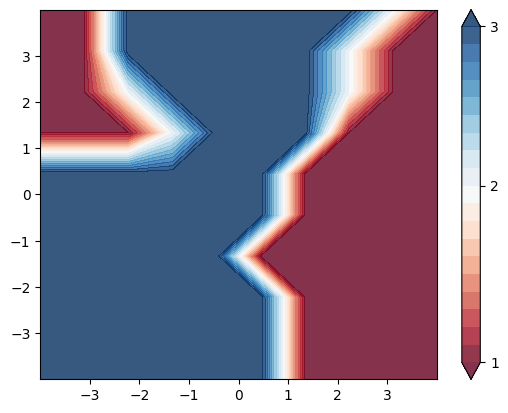

In [33]:
run = 0
iteration = -1
time_now = "2024-05-21 18-02-14"
file_name = "NCL"

folder_name = f"Results/{nqubits}q - {num_iters:} iters"
data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"

# Read the saved data #####################
read_data = pd.read_csv(data_file_name,
                        usecols=["weights",
                                "bias"],
                        converters={"weights":ast.literal_eval,
                                    "bias":ast.literal_eval})
weights = read_data["weights"][run][iteration]
bias = read_data["bias"][run][iteration]

# predictions_grid = [purity(g) for g in gs]
# predictions_grid = [single_loss(jnp.array(weights), jnp.array(bias), gs[i], labels[i]) for i in range(len(gs))]
predictions_grid = [single_pred(jnp.array(weights), jnp.array(bias), gs[i]) for i in range(len(gs))]
# predictions_grid = labels

pred_grid = np.reshape(predictions_grid, xx.shape)

plt.figure()
cm = plt.cm.RdBu

mx = max(predictions_grid)
mn = min(predictions_grid)

# plot decision regions
cnt = plt.contourf(
    xx, yy, pred_grid, levels=np.arange(mn, mx, (mx-mn)/20), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, pred_grid, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[mn, (mx+mn)/2, mx])
# plt.colorbar(cnt, ticks=range(mn, mx+1))


# plt.axis('square')
plt.show()

In [156]:
def plots_sorted_points(nqubits, num_iters, num_runs, time_now, file_name, only_train):
    
    folder_name = f"Results/{nqubits}q - {num_iters:} iters"
    data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"
    
    # Read the saved data #####################
    read_data = pd.read_csv(data_file_name,
                            usecols=["weights",
                                    "bias",
                                    "j_train",
                                    "j_val",
                                    "pred_train",
                                    "pred_val"],
                            converters={"weights":ast.literal_eval,
                                        "bias":ast.literal_eval,
                                        "j_train":ast.literal_eval,
                                        "j_val":ast.literal_eval,
                                        "pred_train":ast.literal_eval,
                                        "pred_val":ast.literal_eval})

    if not only_train:
        j_val = read_data["j_val"][0]
        gs_list_val = []
        labels_list_val = []
        for (j1, j2) in j_val:
            gs_list_val.append(ground_state(j1, j2))
            labels_list_val.append(labeling(j1, j2))


    for run in range(num_runs):
        
        j_train = read_data["j_train"][run]
        gs_list_train = []
        labels_list_train = []
        for (j1, j2) in j_train:
            gs_list_train.append(ground_state(j1, j2))
            labels_list_train.append(labeling(j1, j2))
        
        if only_train:
            js = j_train
            gs_list = gs_list_train
            labels_list = labels_list_train
        else:
            js = j_train + j_val
            gs_list = gs_list_train + gs_list_val
            labels_list = labels_list_train + labels_list_val
        
        last_iter = len(read_data["weights"][run])-1

        weights = read_data["weights"][run][last_iter]
        bias = read_data["bias"][run][last_iter]
        pred_train = read_data["pred_train"][run][last_iter]
        pred_val = read_data["pred_val"][run][last_iter]

        if only_train:
            preds = pred_train
        else:
            preds = pred_train + pred_val

        # Calculate losses #####################
        losses = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(jnp.array(weights), jnp.array(bias), jnp.array(gs_list), jnp.array(labels_list)).tolist()

        # Sort the points by the loss #####################
        table = {}
        table["js"] = js
        table["preds"] = preds
        table["losses"] = losses

        table = pd.DataFrame(table)
        table.sort_values(by=["losses"], inplace=True)

        cv_js = np.array(list(table["js"]))
        cv_preds = np.array(list(table["preds"]))

        # Make the plots #####################

        for i in range(11):
            ratio_ini_points = 0
            ratio_end_points = i/10

            first_point = int(len(cv_js)*ratio_ini_points)
            last_point = int(len(cv_js)*ratio_end_points)

            j_plot = cv_js[first_point:last_point]
            pred_plot = cv_preds[first_point:last_point]

            fig, axis = plt.subplots(1,1)
            
            # define regions coordinates
            x01, y01 = region01_coords[:,0], region01_coords[:,1]
            x02, y02 = region02_coords[:,0], region02_coords[:,1]
            x1, y1 = region1_coords[:,0], region1_coords[:,1]
            x2, y2 = region2_coords[:,0], region2_coords[:,1]
            x3, y3 = region3_coords[:,0], region3_coords[:,1]

            # put the regions into the plot
            axis.fill(x01, y01, facecolor='lightskyblue')    # class 0
            axis.fill(x02, y02, facecolor='lightskyblue')    # class 0
            axis.fill(x1, y1, facecolor='sandybrown')        # class 1
            axis.fill(x2, y2, facecolor='salmon')            # class 2
            axis.fill(x3, y3, facecolor='lightgreen')        # class 3

            colors = ["b", "orange", "r", "g"]

            # plot datapoints
            for i in range(4):
                axis.scatter(
                    j_plot[:, 0][pred_plot==i],
                    j_plot[:, 1][pred_plot==i],
                    c=colors[i],
                    marker="o",
                    edgecolors="k",
                    label=f"class {i+1} train",
                )
            
            # plt.legend()
            axis.axis('square')
            axis.set_title(f"Loss sorted points for run {run}")
            # plt.show()

        only_train_str = "only train" if only_train else "all points"
        plots_pdf_name = f"{folder_name}/{time_now} - Plots loss sorted run {run} - {file_name} {only_train_str}.pdf"
        save_multi_image(plots_pdf_name)
        close_all_figures()
        
# nqubits = 8
# num_iters = 500
# num_runs = 10
# time_now = "2024-04-17 18-20-20"
file_name = "NCL"
only_train = False
plots_sorted_points(nqubits, num_iters, num_runs, time_now, file_name, only_train)

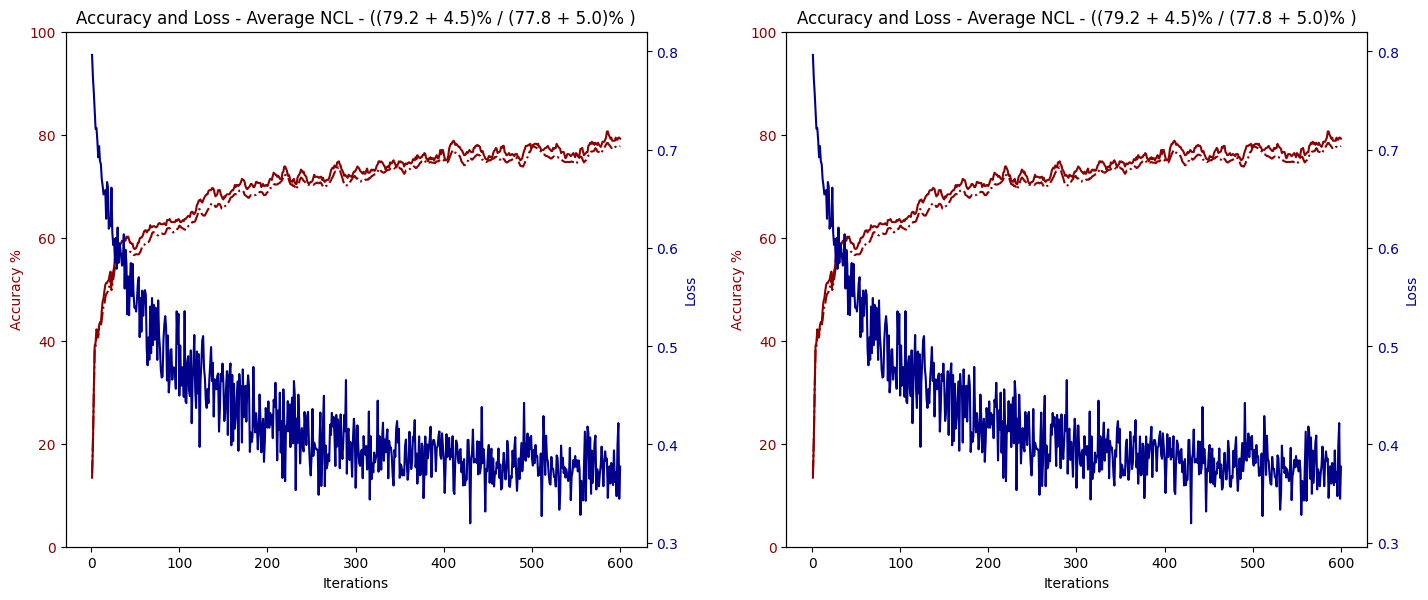

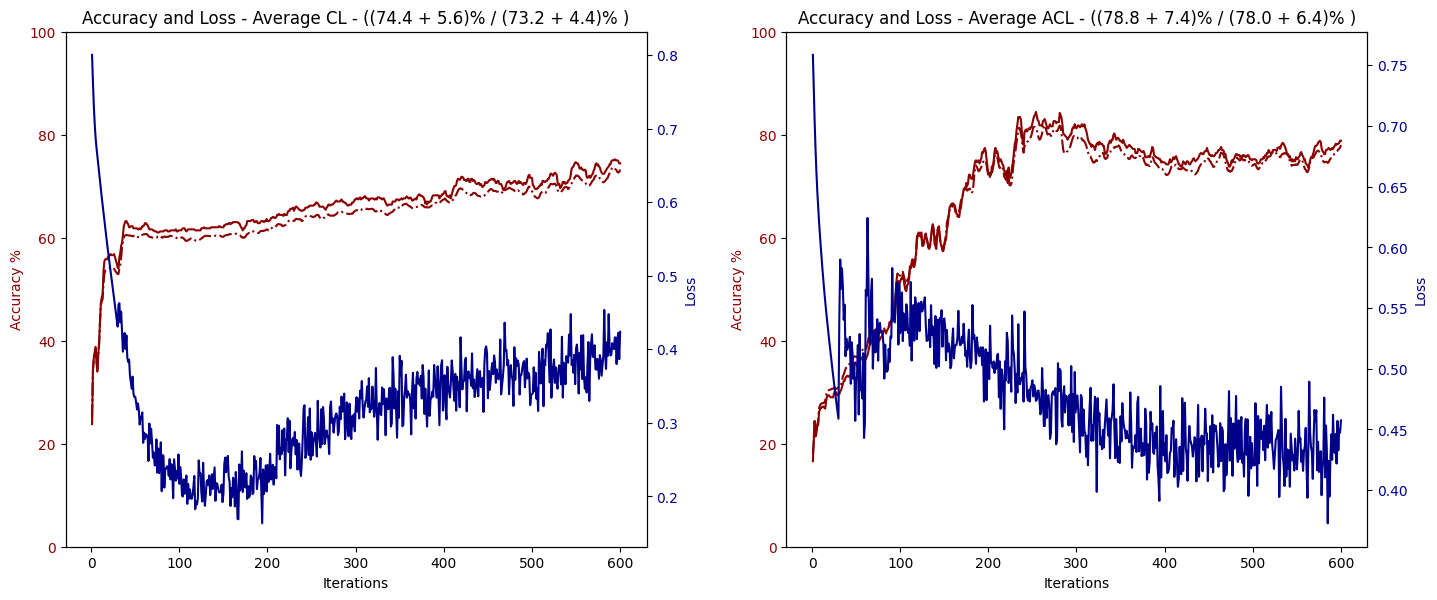

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


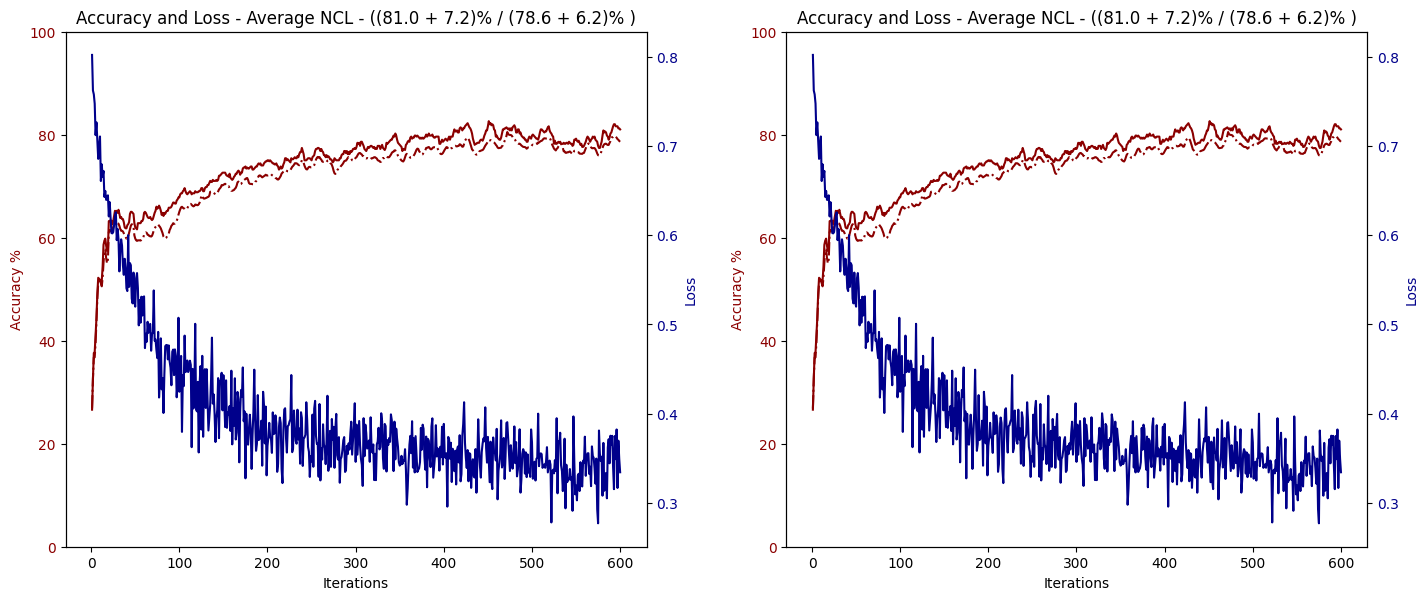

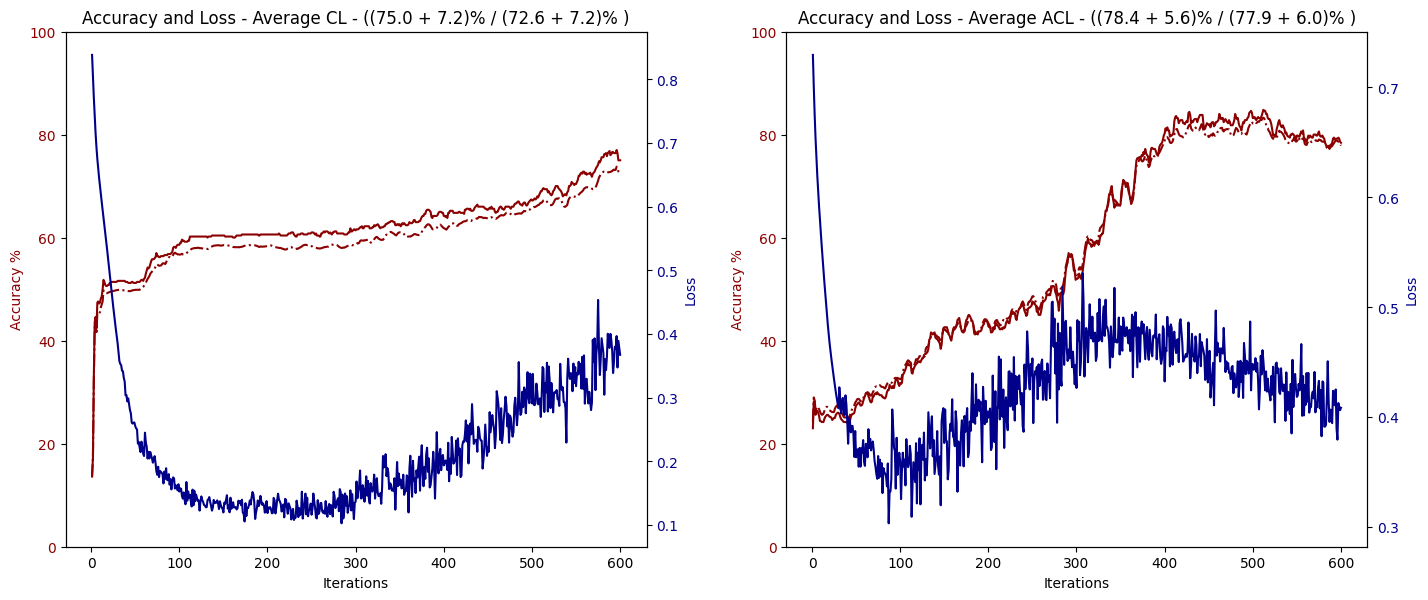

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


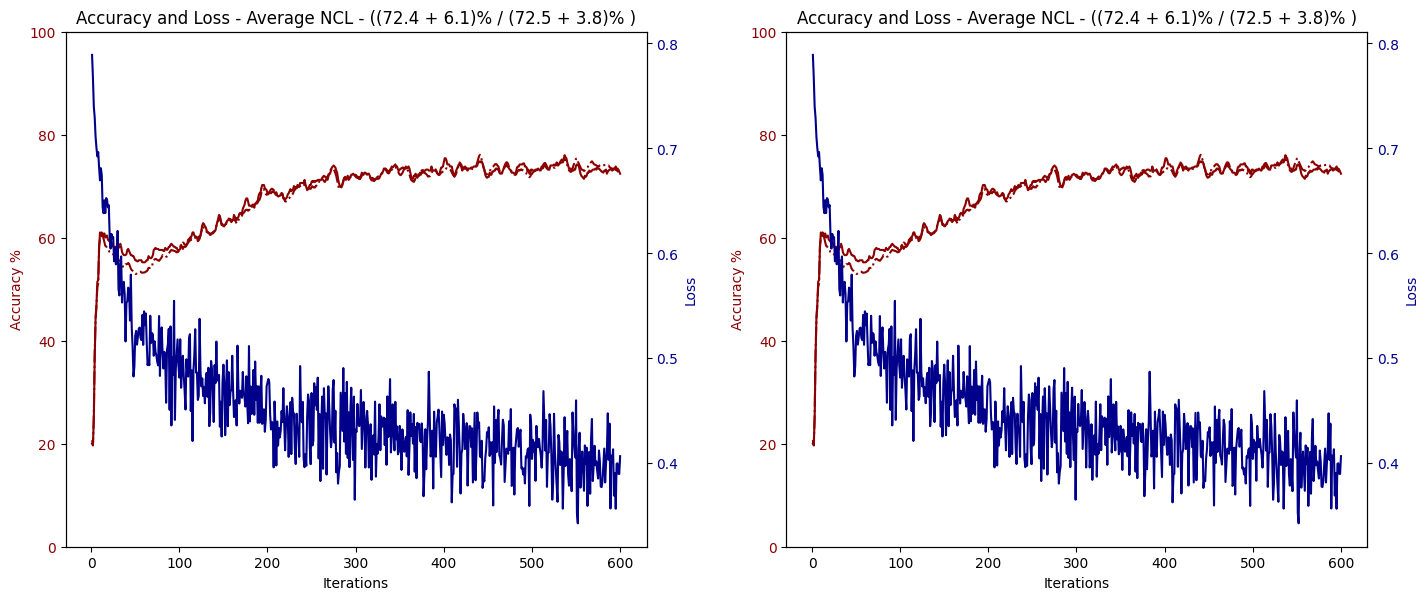

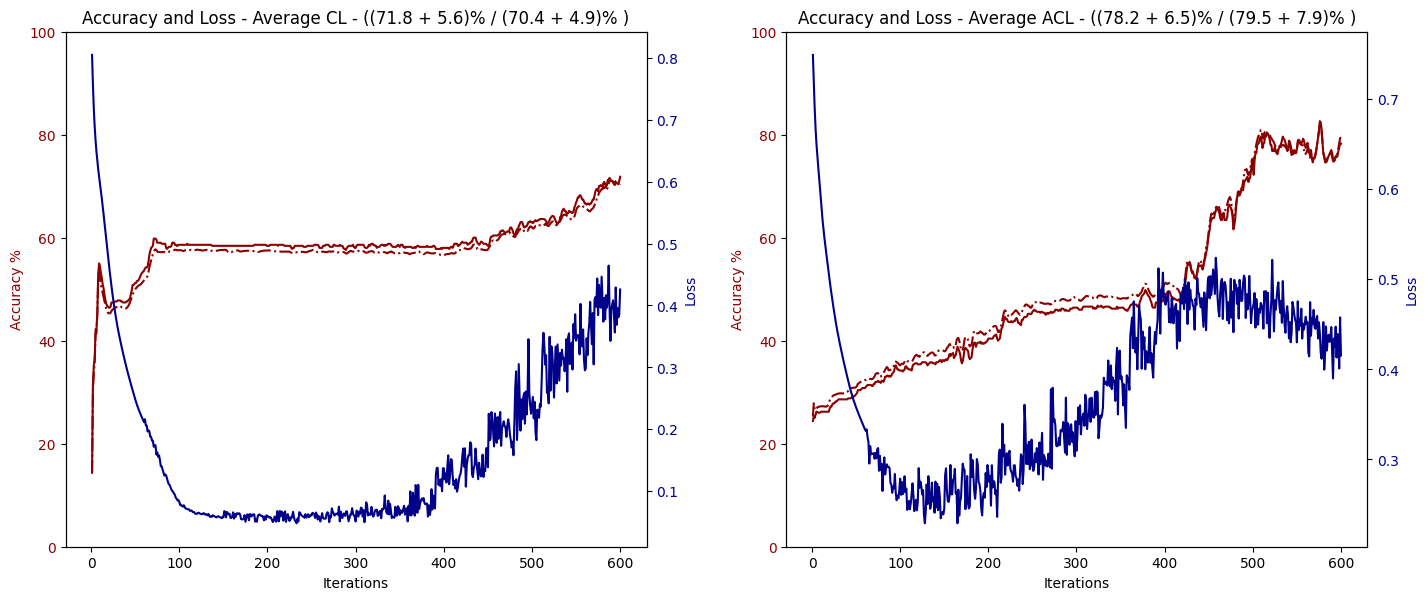

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


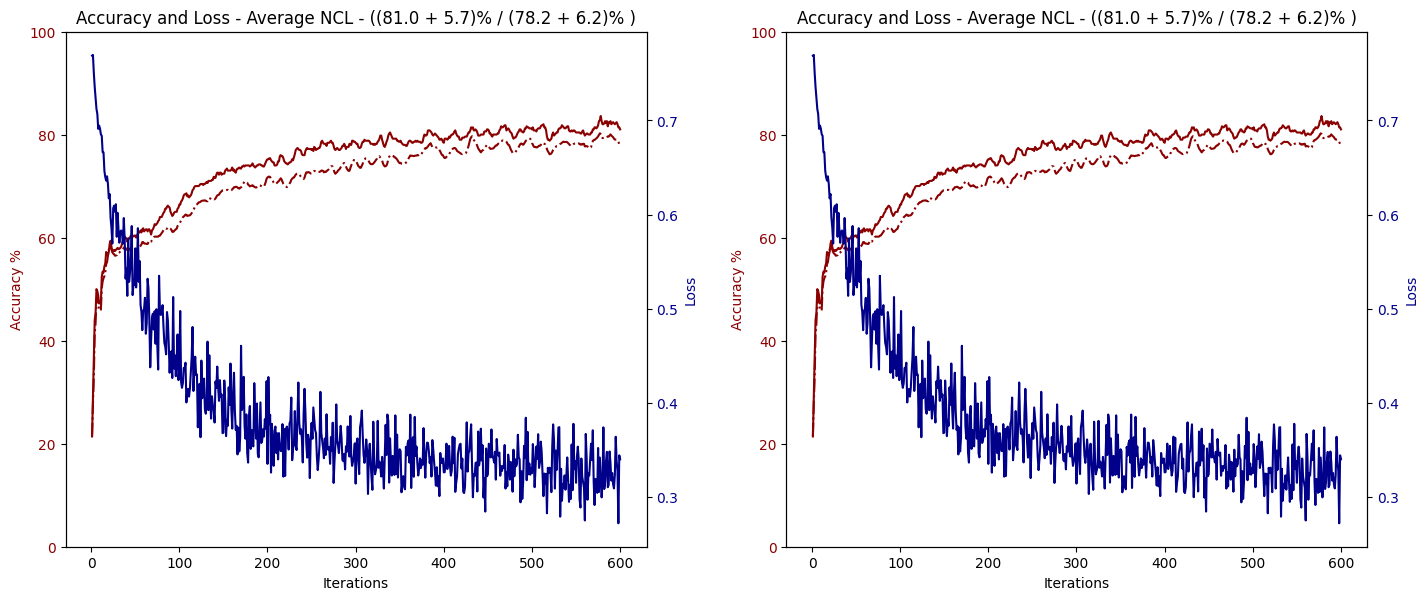

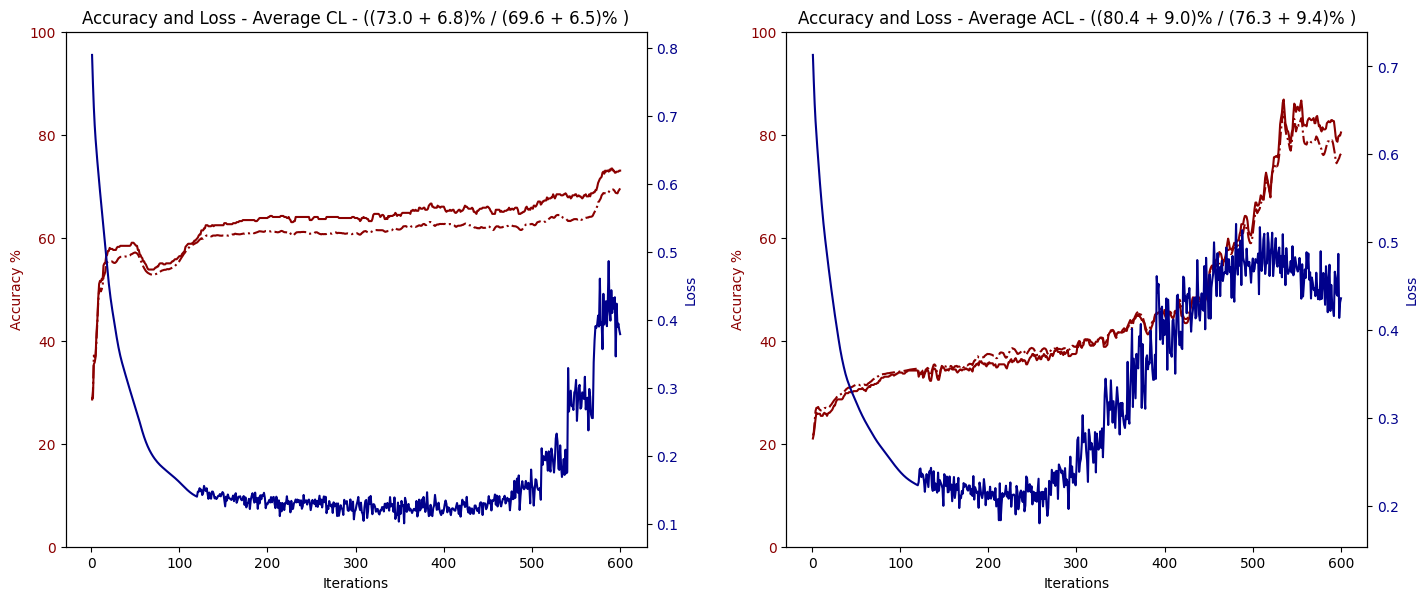

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


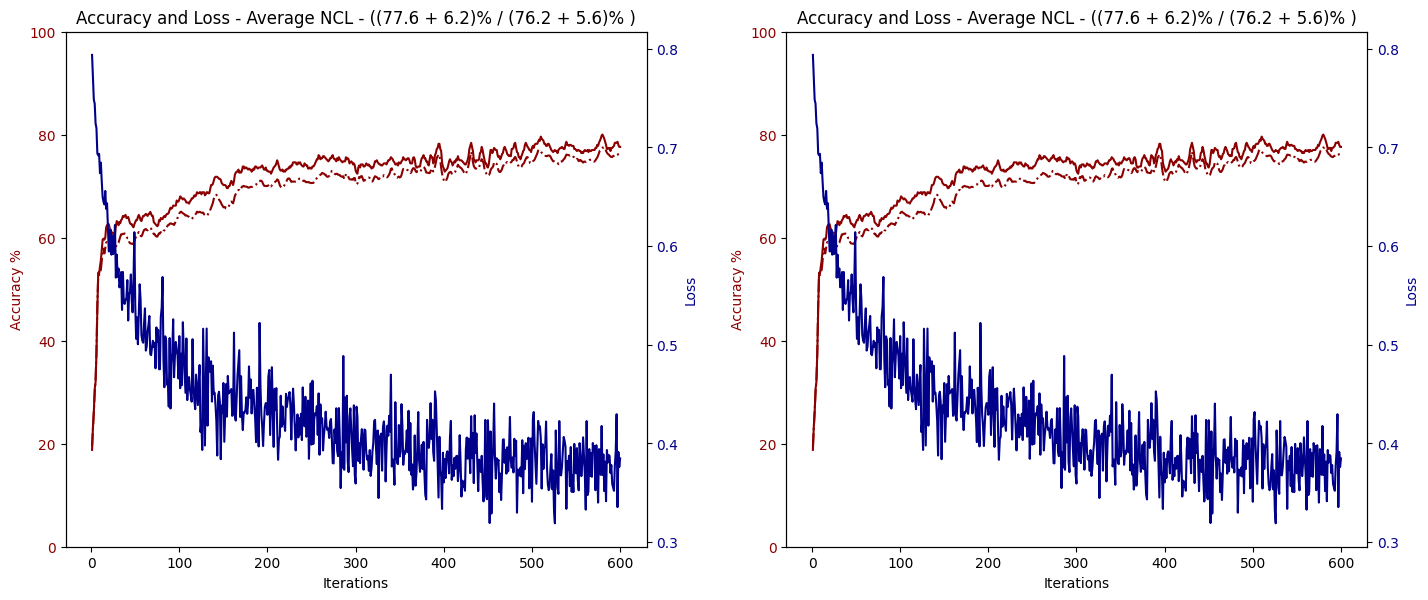

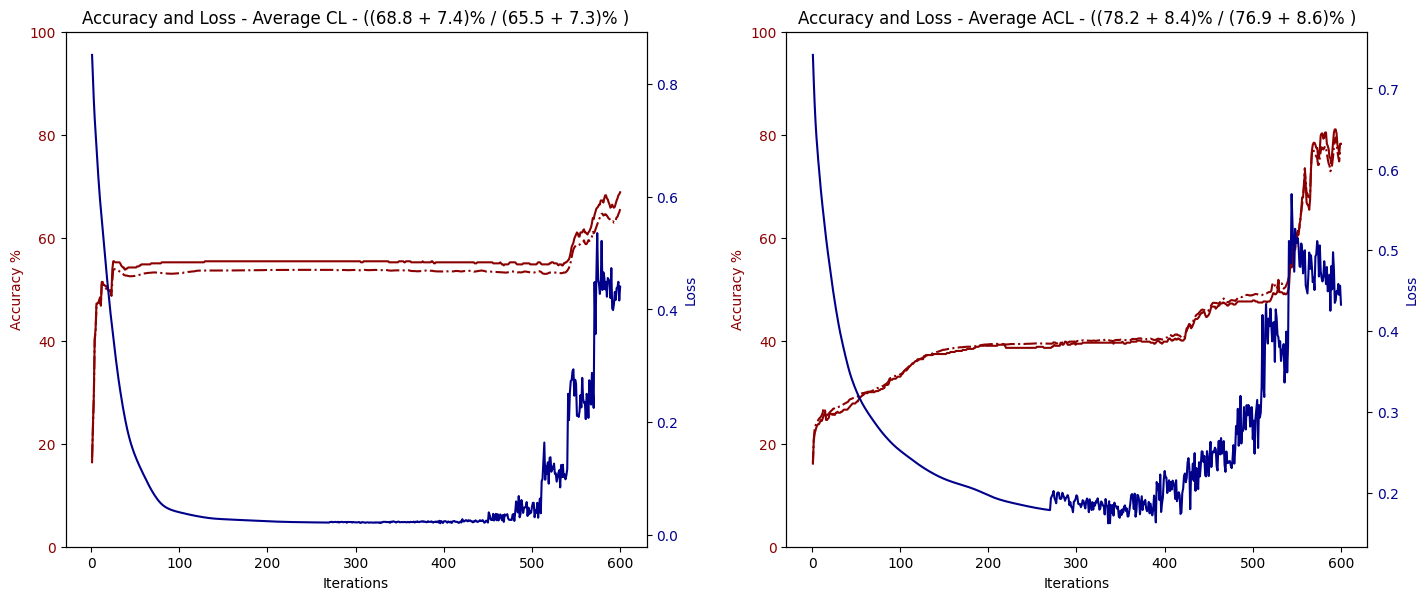

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [28]:
# from matplotlib.gridspec import GridSpec

nqubits = 8
num_iters = 600
num_runs = 10



# arr_file_names = [["NCL","RAND"], ["CL", "ACL"]]
# CL, ACL
## Logarithmic pace
# time_now = "2024-05-30 18-33-00"
## Linear pace
# time_now = "2024-05-30 14-09-59"
## Exponential pace
### exp = 1
# time_now = "2024-06-04 12-13-53"
### exp = 2
# time_now = "2024-05-30 17-37-52"
### exp = 4
# time_now = "2024-06-04 12-48-54"

# arr_file_names = [["CL", "ACL"]]
# times = ["2024-05-30 18-33-00", "2024-05-30 14-09-59", "2024-06-04 12-13-53", "2024-05-30 17-37-52", "2024-06-04 12-48-54"]


# arr_file_names = [["NCL","RAND"], ["PCL", "PACL"]]
# PCL, PACL
## Logarithmic pace
# time_now = "2024-06-04 21-58-21"
## Linear pace
# time_now = "2024-06-04 19-52-12"
## Exponential pace
### exp = 1
# time_now = "2024-06-04 20-55-03"
### exp = 2
# time_now = "2024-06-04 20-23-39"
### exp = 4
# time_now = "2024-06-04 21-26-20"

arr_file_names = [["NCL", "NCL"], ["CL", "ACL"]]
# times = ["2024-07-02 12-43-54", "2024-07-02 13-10-41", "2024-07-02 13-37-07", "2024-07-02 14-03-09", "2024-07-02 14-29-35"]     # ssh PCL, PACL
times = ["2024-07-01 15-33-37", "2024-07-01 16-25-14", "2024-07-01 19-00-05", "2024-07-01 19-27-49", "2024-07-01 19-56-09"]   # ssh CL, ACL
# times = ["2024-07-01 11-40-19", "2024-07-01 12-11-59", "2024-07-01 12-43-27", "2024-07-01 13-14-46", "2024-07-01 13-46-14"]   # gch PCL, PACL
# times = ["2024-06-04 21-58-21", "2024-06-04 19-52-12", "2024-06-04 20-55-03", "2024-06-04 20-23-39", "2024-06-04 21-26-20"]   # gch CL, ACL


# time_now = "2024-06-06 07-03-39"
# [["NCL", "CL", "ACL", "RAND"], ["SPCL", "SPACL", "FSPACL"]]
# arr_file_names = [["NCL","CL","ACL"], ["SPCL","SPACL"], ["PCL", "PACL"]]
# arr_file_names = [["NCL", "RAND", "CL", "ACL"], ["SPCL", "SPACL", "FSPACL"]]
# arr_file_names = [["NCL","RAND"], ["CL", "ACL"]]
# arr_file_names = [["NCL","RAND"], ["PCL", "PACL"]]
# arr_file_names = [["NCL", "RAND", "CL", "ACL"], ["SPCL", "SPACL"]]


# time_now = "2024-06-06 07-03-39" # "2024-06-06 07-03-39" # 10q FSPACL   # "2024-06-05 22-36-33" - 10q all but FSPACL
# arr_file_names = [["NCL", "RAND", "CL", "ACL"], ["SPCL", "SPACL"]]
# arr_file_names = [["FSPACL"]]


# time_now = "2024-06-10 09-55-48"
# arr_file_names = [["NCL", "RAND"], ["CL", "ACL"], ["SPCL", "SPACL", "FSPACL"]]


# times = ["2024-07-21 16-40-18"]
# arr_file_names = [["NCL", "RAND"], ["CL", "ACL"]] # ssh CL, ACL

for time_now in times:

        for file_names in arr_file_names:

                fig, axis = plt.subplots(1,len(file_names))
                fig.set_figheight(6)
                fig.set_figwidth(7*len(file_names))
                fig.tight_layout(pad=2, w_pad=7)

                i = 0
                for file_name in file_names:

                        folder_name = f"Results/{nqubits}q - {num_iters:} iters"
                        data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"

                        # Read the saved data #####################
                        read_data = pd.read_csv(data_file_name,
                                                usecols=["losses",
                                                        "acc_train",
                                                        "acc_val"],
                                                converters={"losses":ast.literal_eval,
                                                        "acc_train":ast.literal_eval,
                                                        "acc_val":ast.literal_eval})

                        all_runs_losses = np.array(list(map(np.array, read_data["losses"])))
                        all_runs_acc_train = np.array(list(map(np.array, read_data["acc_train"])))
                        all_runs_acc_val = np.array(list(map(np.array, read_data["acc_val"])))
                        
                        # We take the averages
                        losses = np.mean(all_runs_losses, axis=0)
                        acc_train = np.mean(all_runs_acc_train, axis=0)
                        acc_val = np.mean(all_runs_acc_val, axis=0)

                        std_acc_train = np.std(all_runs_acc_train, axis=0)
                        std_acc_val = np.std(all_runs_acc_val, axis=0)
                        
                        iterations = range(1, num_iters+1)

                        color1 = 'darkred'
                        axis_i = axis[i]
                        axis_i.set_xlabel('Iterations')
                        axis_i.set_ylabel('Accuracy %', color=color1)
                        axis_i.plot(iterations, acc_train, label="Training", color=color1)
                        axis_i.plot(iterations, acc_val, '-.', label="Validation", color=color1)
                        axis_i.tick_params(axis='y', labelcolor=color1)
                        axis_i.set_ylim(0,100)

                        ax2 = axis_i.twinx()  # instantiate a second axes that shares the same x-axis

                        color2 = 'darkblue'
                        ax2.set_ylabel('Loss', color=color2)  # we already handled the x-label with axis[0]
                        ax2.plot(iterations, losses, label="Loss", color=color2)
                        ax2.tick_params(axis='y', labelcolor=color2)
                        # ax2.set_ylim(bottom=0)

                        # fig.tight_layout()  # otherwise the right y-label is slightly clipped
                        # plt.legend()
                        axis_i.set_title(f"Accuracy and Loss - Average {file_name} - (({round(acc_train[num_iters-1], 1)} + {round(std_acc_train[num_iters-1], 1)})% / ({round(acc_val[num_iters-1], 1)} + {round(std_acc_val[num_iters-1], 1)})% )")
                        
                        i += 1
                        
                plt.show()
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

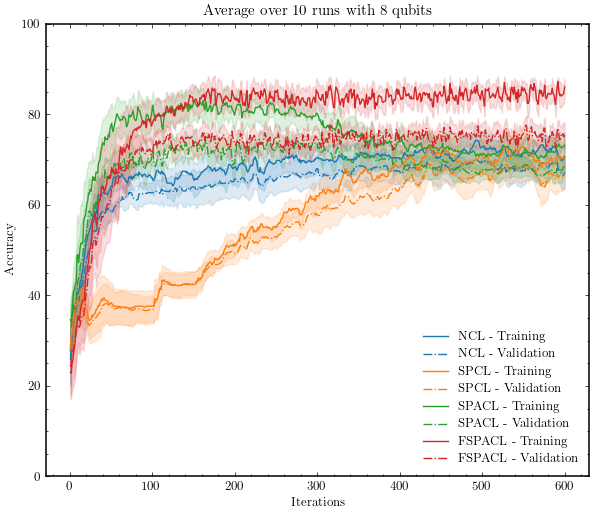

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import ast
import numpy as np
import scienceplots
import latex

nqubits = 8
time_now = "2024-05-20 11-20-27"

# file_names = ["NCL","RAND","CL","ACL"] #1
# file_names = ["NCL","SPCL","SPACL","FSPACL"] #2
# file_names = ["NCL","RAND"] #3

data_file_names = []
for file_name in file_names:
    data_file_names.append(f"{time_now} - Data - {file_name}.csv")

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fontfig = 9
plt.rcParams.update({'font.size': fontfig})
plt.rcParams.update({'font.family': 'times'})


with plt.style.context(['science', 'std-colors']):
    
    plt.rcParams['axes.linewidth'] = 1.10
    fig, axis = plt.subplots(1,1)
    fig.set_figheight(5)
    fig.set_figwidth(6)
    fig.tight_layout()
    
    i=0
    for data_file_name in data_file_names:
        
        # Read the saved data #####################
        read_data = pd.read_csv(data_file_name,
                                usecols=["losses",
                                        "acc_train",
                                        "acc_val"],
                                converters={"losses":ast.literal_eval,
                                        "acc_train":ast.literal_eval,
                                        "acc_val":ast.literal_eval})

        all_runs_losses = np.array(list(map(np.array, read_data["losses"])))
        all_runs_acc_train = np.array(list(map(np.array, read_data["acc_train"])))
        all_runs_acc_val = np.array(list(map(np.array, read_data["acc_val"])))
        
        # We take the averages
        losses = np.mean(all_runs_losses, axis=0)
        acc_train = np.mean(all_runs_acc_train, axis=0)
        acc_val = np.mean(all_runs_acc_val, axis=0)

        std_losses = np.std(all_runs_losses, axis=0)
        std_acc_train = np.std(all_runs_acc_train, axis=0)
        std_acc_val = np.std(all_runs_acc_val, axis=0)
        
        iterations = range(1, len(read_data["losses"][0])+1)

        axis.plot(iterations, acc_train, label=file_names[i]+" - Training", color=colors[i])
        axis.fill_between(iterations, acc_train - std_acc_train/2, acc_train + std_acc_train/2, color=colors[i], alpha=0.15)
        axis.plot(iterations, acc_val, '-.', label=file_names[i]+" - Validation", color=colors[i])
        axis.fill_between(iterations, acc_val - std_acc_val/2, acc_val + std_acc_val/2, color=colors[i], alpha=0.15)
        i+=1

    axis.set_xlabel('Iterations')
    axis.set_ylabel('Accuracy %')
    axis.set_ylim(0,100)
    axis.set_title(f"Average over {len(all_runs_acc_val)} runs with {nqubits} qubits")                
    plt.legend(loc="lower right")
    plt.show()

In [22]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
# OLD

from matplotlib import *
import scienceplots
import latex

# nqubits = 8
# num_iters = 600

# time_now = "2024-04-25 14-14-42"
# file_names = ["NCL","CL","ACL","SPCL","SPACL","PCL","PACL"]


# time_now = "2024-04-25 14-14-42" #1
# file_names = ["NCL","RAND","CL","ACL"] #1

# time_now = "2024-04-22 17-37-39" #2
# file_names = ["NCL","SPCL","SPACL","FSPACL"] #2

# time_now = "2024-04-25 14-14-42" #3
# file_names = ["NCL","RAND"] #3

file_names = ["NCL", "RAND", "CL", "ACL"] #, ["SPCL", "SPACL", "FSPACL"]]

data_file_names = []
for file_name in file_names:
    folder_name = f"Results/{nqubits}q - {num_iters:} iters"
    data_file_names.append(f"{folder_name}/{time_now} - Data - {file_name}.csv")

# time_now = "2024-04-24 11-54-00" #2
# file_name = "SPACL"
# data_file_names.append(f"{folder_name}/{time_now} - Data - {file_name}.csv")
# file_names.append("FSPACL")

# time_now = "2024-04-22 17-37-39" #3
# file_names2 = ["PCL","PACL"]
# for file_name in file_names2:
#     data_file_names.append(f"{folder_name}/{time_now} - Data - {file_name}.csv")
#     file_names.append(file_name)




# colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf']

fontfig = 9
column_width = 246 * 0.01389

mksize = 4.5
lwfig = 1.

plt.rcParams.update({'font.size': fontfig})
plt.rcParams.update({'font.family': 'times'})


with plt.style.context(['science', 'std-colors']):
    
    plt.rcParams['axes.linewidth'] = 1.10
    # fig, axis = plt.subplots(figsize =(4.8 / 6.4 * column_width , column_width))
    fig, axis = plt.subplots(1,1)
    fig.set_figheight(5)
    fig.set_figwidth(6)
    fig.tight_layout()
    
    i=0
    for data_file_name in data_file_names:
        
        # Read the saved data #####################
        read_data = pd.read_csv(data_file_name,
                                usecols=["losses",
                                        "acc_train",
                                        "acc_val"],
                                converters={"losses":ast.literal_eval,
                                        "acc_train":ast.literal_eval,
                                        "acc_val":ast.literal_eval})

        all_runs_losses = np.array(list(map(np.array, read_data["losses"])))
        all_runs_acc_train = np.array(list(map(np.array, read_data["acc_train"])))
        all_runs_acc_val = np.array(list(map(np.array, read_data["acc_val"])))

        # We take the averages
        losses = np.mean(all_runs_losses, axis=0)
        acc_train = np.mean(all_runs_acc_train, axis=0)
        acc_val = np.mean(all_runs_acc_val, axis=0)

        std_losses = np.std(all_runs_losses, axis=0)
        std_acc_train = np.std(all_runs_acc_train, axis=0)
        std_acc_val = np.std(all_runs_acc_val, axis=0)
        
        iterations = range(1, num_iters+1)

        axis.plot(iterations, acc_train, label=file_names[i]+" - Training", color=colors[i])
        axis.fill_between(iterations, acc_train - std_acc_train/2, acc_train + std_acc_train/2, color=colors[i], alpha=0.15)
        axis.plot(iterations, acc_val, '-.', label=file_names[i]+" - Validation", color=colors[i])
        axis.fill_between(iterations, acc_val - std_acc_val/2, acc_val + std_acc_val/2, color=colors[i], alpha=0.15)
        i+=1

    axis.set_xlabel('Iterations')
    axis.set_ylabel('Accuracy %')
    axis.set_ylim(0,100)
    axis.set_title(f"Average over {len(all_runs_acc_val)} runs with {nqubits} qubits")                
    plt.legend(loc="lower right")
    plt.show()

In [35]:
run = 0
iteration = -1
time_now = "2024-05-23 19-13-08" # "2024-05-22 18-43-25" "2024-05-23 19-13-08"  #"2024-05-21 18-02-14"
file_name = "FSPACL"
num_points = 100

folder_name = f"Results/{nqubits}q - {num_iters:} iters"
data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"

# Read the saved data #####################
read_data = pd.read_csv(data_file_name,
                        usecols=["weights",
                                "bias"],
                        converters={"weights":ast.literal_eval,
                                    "bias":ast.literal_eval})
weights = read_data["weights"][run][iteration]
bias = read_data["bias"][run][iteration]

xx = 1*np.ones(num_points) #np.linspace(0, 3, num_points) 
yy = np.linspace(-4, 4, num_points) # 3*np.ones(num_points)
X_grid = np.array([np.array([x, y]) for x, y in zip(xx, yy)])

# print(X_grid)
# [print(j1, j2) for j1,j2 in X_grid]

# gs = jax.vmap(ground_state, in_axes=(0,0))(X_grid[:,0],X_grid[:,1])
gs = [ground_state(j1, j2) for j1,j2 in X_grid]
probs = np.array([variational_classifier(weights, np.array(bias), g) for g in gs])


In [103]:
np.savetxt("2nd Hamiltonian - FSPACL probs.csv", probs,  delimiter = ",")


In [106]:
probs = pd.read_csv("2nd Hamiltonian - FSPACL probs.csv", header=None).to_numpy()
print(probs)

[[0.14584238 0.55139127 0.13663983 0.16612653]
 [0.14391195 0.55105866 0.14068167 0.16434772]
 [0.14196317 0.55045407 0.14507281 0.16250995]
 [0.13998844 0.54953823 0.14985155 0.16062178]
 [0.13798121 0.54826233 0.15506002 0.15869644]
 [0.13593625 0.54656829 0.16074278 0.15675269]
 [0.13385015 0.54438942 0.16694479 0.15481564]
 [0.1317218  0.54165206 0.17370864 0.15291749]
 [0.12955286 0.53827807 0.18107097 0.1510981 ]
 [0.12734828 0.53418871 0.18905805 0.14940496]
 [0.12511664 0.52930986 0.19768085 0.14789265]
 [0.12287038 0.52357844 0.20692989 0.14662129]
 [0.12062558 0.51694975 0.21677059 0.14565408]
 [0.1184015  0.50940477 0.22714004 0.14505369]
 [0.11621952 0.50095625 0.23794616 0.14487807]
 [0.11410181 0.4916525  0.24906985 0.14517585]
 [0.11206969 0.48157752 0.26037053 0.14598227]
 [0.11014204 0.47084722 0.27169452 0.14731621]
 [0.10833395 0.45960189 0.28288523 0.14917893]
 [0.10665581 0.44799605 0.29379345 0.15155469]
 [0.10511303 0.43618742 0.30428643 0.15441312]
 [0.10370634 

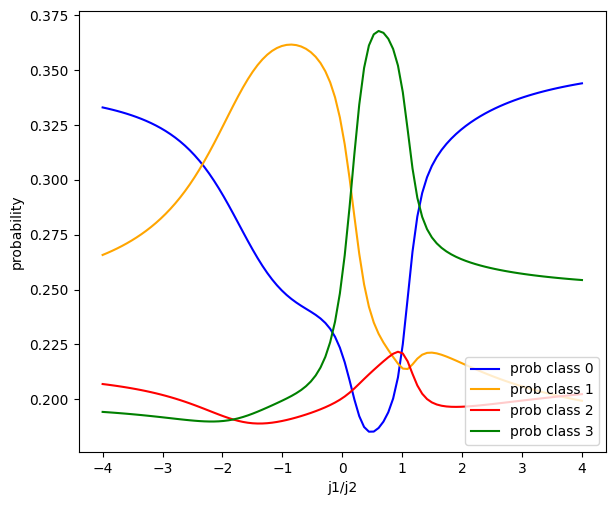

In [36]:
fig, axis = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(6)
fig.tight_layout()

x_axis = yy

p00 = probs[:,0]
p01 = probs[:,1]
p10 = probs[:,2]
p11 = probs[:,3]

axis.plot(x_axis, p00, label="prob class 0", color="blue")
axis.plot(x_axis, p01, label="prob class 1", color="orange")
axis.plot(x_axis, p10, label="prob class 2", color="red")
axis.plot(x_axis, p11, label="prob class 3", color="green")

# axis.plot(x_axis, p00, label="prob class null", color="grey")
# axis.plot(x_axis, p01, label="prob class 1", color="red")
# axis.plot(x_axis, p10, label="prob class 2", color="blue")
# axis.plot(x_axis, p11, label="prob class 3", color="orange")

axis.set_xlabel('j1/j2')
axis.set_ylabel('probability')
axis.set_title(f"")
plt.legend(loc="lower right")
plt.show()


In [63]:
g0 = ground_state(0, 3)

probs0 = variational_classifier(weights, np.array(bias), g0)
print(probs0)

pred0 = single_pred(weights, np.array(bias), g0)
print(pred0)

[0.26182244 0.26545094 0.2216691  0.25105751]
1
[0.22866416025198494, -0.2597938159428621, -0.10982566809673171, 0.5951496479358779, 0.6288908390110953, 0.20143830143979874, -0.1959054968286737, -0.7104888101823084, 0.3586923267374155, 0.4362377263638697, -0.3324282001672633, 0.09059295670321818, -0.2815303027090351, -0.14221412314388898, -0.3057974999163828, -0.42254313494235707, -0.36986382881344626, -0.38332847289389765, 0.04653316525181634, 0.448059277795038, 0.4746832068175242, -0.7337803981093559, 0.41173984447460527, 0.634933706254944, -0.5046386967644302, -0.2874589362948493, -0.26154013224351913, -0.375688687241087, -0.08905775340999864, 0.030873340244140752, -0.05718070142996926, -0.04614653784575052, -0.1189377637933384, -0.07067412189474372, 0.1503992561405469, -0.4381831588368861, -0.2123473832949502, 0.9379345848630781, -0.0829851529499243, 0.9610280237165884, -0.1661019370871717, -0.16397576318420795, 0.24911512552427964, -0.0904995605249699, 0.12592638421182806, 1.37759

In [20]:
run = 0
iteration = -1
time_now = "2024-05-23 19-13-08"  #"2024-05-21 18-02-14"
file_name = "FSPACL"

read_data = pd.read_csv(data_file_name,
                        usecols=["weights",
                                "bias",
                                "j_val",
                                "pred_val"],
                        converters={"weights":ast.literal_eval,
                                    "bias":ast.literal_eval,
                                    "j_val":ast.literal_eval,
                                    "pred_val":ast.literal_eval})

weights = read_data["weights"][run][iteration]
bias = read_data["bias"][run][iteration]
j_val = np.array(read_data["j_val"][run])


# margin = 0.01
# x = j_val[:, 0]
# y = j_val[:, 0]
# new_j = np.array(list(zip(x[(x>1-margin) * (x<1+margin)], y[(y>-3-margin) * (y<-3+margin)])))
# j_val = new_j


# gs2 = np.array([ground_state(j1, j2) for j1, j2 in j_val])
gs2 = jax.vmap(ground_state, in_axes=[0,0])(j_val[:,0], j_val[:,1])


NameError: name 'data_file_name' is not defined

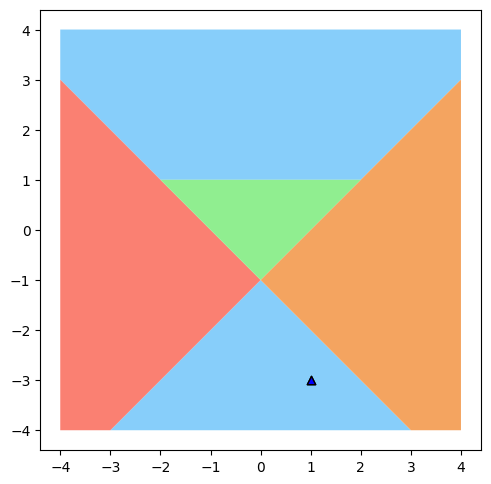

In [111]:
# pred_val = np.array(read_data["pred_val"][run][iteration])
pred_val = pred(weights, np.array(bias), gs2)


fig, axis = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(6)
fig.tight_layout()

plot_iter = -1

# define regions coordinates
x01, y01 = region01_coords[:,0], region01_coords[:,1]
x02, y02 = region02_coords[:,0], region02_coords[:,1]
x1, y1 = region1_coords[:,0], region1_coords[:,1]
x2, y2 = region2_coords[:,0], region2_coords[:,1]
x3, y3 = region3_coords[:,0], region3_coords[:,1]

# put the regions into the plot
axis.fill(x01, y01, facecolor='lightskyblue')    # class 0
axis.fill(x02, y02, facecolor='lightskyblue')    # class 0
axis.fill(x1, y1, facecolor='sandybrown')        # class 1
axis.fill(x2, y2, facecolor='salmon')            # class 2
axis.fill(x3, y3, facecolor='lightgreen')        # class 3

# pred_val_plot = np.array(pred_val[plot_iter])
pred_val_plot = pred_val

colors = ["b", "orange", "r", "g"]

# plot datapoints
for i in range(4):
    # axis.scatter(
    #     j_train[:, 0][pred_train_plot==i],
    #     j_train[:, 1][pred_train_plot==i],
    #     c=colors[i],
    #     marker="o",
    #     edgecolors="k",
    #     label=f"class {i+1} train",
    # )
    if with_val:
        axis.scatter(
            j_val[:, 0][pred_val_plot==i],
            j_val[:, 1][pred_val_plot==i],
            c=colors[i],
            marker="^",
            edgecolors="k",
            label=f"class {i+1} validation",
        )


# plt.legend()
# axis.set_title(f"Validation ({acc_val[plot_iter]:.0f}%)")
plt.axis('square')
plt.show()

In [120]:
print(j_val[0])
print(j_val[:,0])
print(j_val[:,1])

[ 1.00390721 -2.99550541]
[1.00390721 1.00669019]
[-2.99550541 -3.00108419]


In [119]:
print(gs2[0])
predgs20 = single_pred(weights, np.array(bias), gs2[0])
print(predgs20)

[-4.47231575e-02 -5.55111512e-17 -2.22044605e-16  4.11294078e-02
  0.00000000e+00  7.63723630e-02  4.11294078e-02 -1.38777878e-17
  4.16333634e-17 -1.19300060e-02  7.63723630e-02 -8.34835673e-18
  4.11294078e-02 -1.01542310e-17 -1.52273231e-17  1.03565669e-01
 -8.63623612e-18 -7.73668594e-02 -1.19300060e-02  4.29226752e-18
  7.63723630e-02  1.11271544e-18  3.76102750e-17 -1.94579217e-02
  4.11294078e-02 -1.90105596e-18 -1.56683497e-17  9.74749317e-02
  8.93710694e-18 -1.94579217e-02  1.03565669e-01 -1.55946099e-18
  4.20701949e-17  4.11294078e-02  7.63723630e-02 -1.60650980e-17
 -1.19300060e-02 -7.70395969e-18 -1.20879754e-17  1.03565669e-01
 -7.73668594e-02 -1.21086026e-18 -1.22695971e-17 -1.94579217e-02
 -1.45821764e-18  9.74749317e-02 -1.94579217e-02 -1.27455588e-17
 -1.19300060e-02  4.36280042e-18  4.77657165e-18 -1.10174281e-01
 -4.48485944e-18 -2.92251329e-02 -1.16265018e-01  1.14814789e-17
 -1.91241645e-18  9.28306035e-02 -2.92251329e-02 -1.60587962e-18
 -1.10174281e-01  8.07952

In [108]:
margin = 0.01
x = j_val[:, 0]
y = j_val[:, 0]
new_j = np.array(list(zip(x[(x>1-margin) * (x<1+margin)], y[(y>-3-margin) * (y<-3+margin)])))
# print((x>0.9) * (x<1.1))
print(new_j)

[[ 1.00390721 -2.99550541]
 [ 1.00669019 -3.00108419]]


In [118]:
g0 = ground_state(*j_val[0])
print(g0)

probs0 = variational_classifier(weights, np.array(bias), g0)
print(probs0)

pred0 = single_pred(weights, np.array(bias), g0)
print(pred0)

[-4.47231575e-02+0.j -5.55111512e-17+0.j -4.99600361e-16+0.j
  4.11294078e-02+0.j -5.43259533e-16+0.j  7.63723630e-02+0.j
  4.11294078e-02+0.j -6.50072002e-17+0.j  1.25798909e-17+0.j
 -1.19300060e-02+0.j  7.63723630e-02+0.j -1.25894378e-18+0.j
  4.11294078e-02+0.j -8.15698725e-18+0.j -1.46348455e-17+0.j
  1.03565669e-01+0.j -4.91595504e-20+0.j -7.73668594e-02+0.j
 -1.19300060e-02+0.j  4.88018923e-18+0.j  7.63723630e-02+0.j
  5.73569937e-19+0.j  1.88923514e-17+0.j -1.94579217e-02+0.j
  4.11294078e-02+0.j -3.46680263e-18+0.j -1.01239287e-17+0.j
  9.74749317e-02+0.j  3.42041997e-18+0.j -1.94579217e-02+0.j
  1.03565669e-01+0.j -1.96742065e-18+0.j -2.19561614e-18+0.j
 -1.19300060e-02+0.j -7.73668594e-02+0.j  6.16864338e-18+0.j
 -1.19300060e-02+0.j  1.07050038e-17+0.j  5.98230174e-18+0.j
 -1.10174281e-01+0.j  7.63723630e-02+0.j  2.30179683e-18+0.j
  2.51814225e-17+0.j -2.92251329e-02+0.j  6.03004869e-18+0.j
 -1.16265018e-01+0.j -1.94579217e-02+0.j  1.30887964e-17+0.j
  4.11294078e-02+0.j -3.

In [145]:
print(j_val[0,0], j_val[0,1])

gs2 = jax.vmap(ground_state, in_axes=[0,0])(jnp.array([j_val[0,0]]),jnp.array([j_val[0,1]]))
# gs2 = jax.vmap(ground_state, in_axes=[0,0])(j_val[:,0], j_val[:,1])
# gs2 = [ground_state(j1,j2) for j1, j2 in zip(j_val[:,0], j_val[:,1])]
# print(gs2[0])
predgs20 = single_pred(weights, np.array(bias), gs2[0])
print(predgs20)

print(*j_val[0])
g0 = ground_state(j_val[0,0], j_val[0,1])
# print(g0)
predg0 = single_pred(weights, np.array(bias), g0)
print(predg0)

1.0039072120172623 -2.9955054076226544
0
1.0039072120172623 -2.9955054076226544
1


In [157]:
a = 1
b = -3

gs2 = jax.vmap(ground_state, in_axes=[0,0])(jnp.array([a]),jnp.array([b]))
predgs20 = single_pred(weights, np.array(bias), gs2[0])
print(predgs20)

g0 = ground_state(a, b)
predg0 = single_pred(weights, np.array(bias), g0)
print(predg0)

print((gs2==g0).all())

0
1
False


In [1]:
# ISSUE PENNYLANE

import pennylane as qml
import jax
import numpy as np
import jax.numpy as jnp

def I(i):
    return qml.Identity(i)
def X(i):
    return qml.PauliX(i)
def Y(i):
    return qml.PauliY(i)
def Z(i):
    return qml.PauliZ(i)

nqubits = 4

def ground_state(j1, j2):
    
    hamiltonian = 0
    
    for i in range(nqubits):
        hamiltonian += Z(i)
        hamiltonian -= j1 * X(i) @ X((i+1)%nqubits)
        hamiltonian -= j2 * X((i-1)%nqubits) @ Z(i) @ X((i+1)%nqubits)
    
    print(hamiltonian)
    print(type(hamiltonian))
    
    ham_matrix = qml.matrix(hamiltonian)
    _, eigvecs = jnp.linalg.eigh(ham_matrix)
    
    return eigvecs[:,0]


j1 = 1
j2 = -3

gs = jax.vmap(ground_state, in_axes=[0,0])(np.array([j1]),np.array([j2]))
g0 = ground_state(j1, j2)

print((gs[0]==g0).all())

print(gs[0])
print(g0)

Z(0) + -1 * ((Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = array([1])
  batch_dim = 0 * X(0)) @ X(1)) + -1 * ((Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = array([-3])
  batch_dim = 0 * X(3)) @ Z(0) @ X(1)) + Z(1) + -1 * ((Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = array([1])
  batch_dim = 0 * X(1)) @ X(2)) + -1 * ((Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = array([-3])
  batch_dim = 0 * X(0)) @ Z(1) @ X(2)) + Z(2) + -1 * ((Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = array([1])
  batch_dim = 0 * X(2)) @ X(3)) + -1 * ((Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = array([-3])
  batch_dim = 0 * X(1)) @ Z(2) @ X(3)) + Z(3) + -1 * ((Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = array([1])
  batch_dim = 0 * X(3)) @ X(0)) + -1 * ((Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = array([-3])
  batch_dim =